In [2]:
import numpy as np
import pandas as pd
import shap
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})

from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix, classification_report

import lightgbm as lgb

In [3]:
df_public = pd.read_csv('csv_data/df_public_test.csv', index_col='Unnamed: 0')
df_private = pd.read_csv('csv_data/df_private_test.csv', index_col='Unnamed: 0')

In [4]:
df_NR = pd.read_csv('csv_data/df_NR.csv', index_col='Unnamed: 0')
df_ER = pd.read_csv('csv_data/df_ER.csv', index_col='Unnamed: 0')
df = pd.concat([df_NR, df_ER])

In [5]:
df.head()

N_bkgr_only_x  N_bkgr_only_y  N_error_bkgr_only_x  N_error_bkgr_only_y  \
0   1.445476e+06   1.445571e+06          1202.279529          1202.319211   
1   1.444762e+06   1.444869e+06          1201.982422          1202.027072   
2   1.457226e+06   1.457315e+06          1207.156241          1207.193097   
3   1.447220e+06   1.447342e+06          1203.004409          1203.055289   
4   1.447794e+06   1.447899e+06          1203.243010          1203.286578   

     N_error_x    N_error_y           N_x           N_y  bkgr_count_x  \
0  1202.281860  1202.319856  1.445482e+06  1.445573e+06  1.446074e+06   
1     0.000000  1202.028233  1.832608e+06  1.444872e+06  1.331175e+06   
2  1207.305566  1207.349531  1.457587e+06  1.457693e+06  1.446322e+06   
3  1203.015877  1203.065822  1.447247e+06  1.447367e+06  1.443786e+06   
4  1203.256044  1203.296514  1.447825e+06  1.447923e+06  1.444089e+06   

   bkgr_count_y  ...      sigma_x   sigma_y  tolerance_bkgr_only_x  \
0  1.445101e+06  ...     1.418332  3.067164                    0.1   
1  1.443962e+06  ...   206.965796  5.779184                    0.1   
2  1.446692e+06  ...     6.413964  5.924996                    0.1   
3  1.444582e+06  ...     7.764097  5.870479                    0.1   
4  1.445411e+06  ...     7.908807  5.172748                    0.1   

   tolerance_bkgr_only_y  tolerance_x  tolerance_y  up_bkgr_only_x  \
0                    0.1          0.1          0.1             1.0   
1                    0.1          0.1          0.1             1.0   
2                    0.1          0.1          0.1             1.0   
3                    0.1          0.1          0.1             1.0   
4                    0.1          0.1          0.1             1.0   

   up_bkgr_only_y  up_x  up_y  
0             1.0   1.0   1.0  
1             1.0   1.0   1.0  
2             1.0   1.0   1.0  
3             1.0   1.0   1.0  
4             1.0   1.0   1.0  

[5 rows x 116 columns]

In [6]:
# feat_list = ['N_error_x', 'N_error_y', 'N_x', 'N_y', 'bkgr_count_x', 'bkgr_count_y',
#        'chi2_pvalue_x', 'chi2_pvalue_y', 'chi2_x', 'chi2_y', 'dfr', 'dmu',
#        'dsigma', 'edm_x', 'edm_y', 'event_ID', 'event_angle', 'event_class',
#        'event_energy', 'fr_error_x', 'fr_error_y', 'fr_x', 'fr_y', 'fval_x',
#        'fval_y', 'has_accurate_covar_x', 'has_accurate_covar_y',
#        'has_covariance_x', 'has_covariance_y', 'has_made_posdef_covar_x',
#        'has_made_posdef_covar_y',
#        'has_posdef_covar_x', 'has_posdef_covar_y',
#        'has_reached_call_limit_x', 'has_reached_call_limit_y',
#        'hesse_failed_x', 'hesse_failed_y', 'image_name',
#         'is_valid_x', 'is_valid_y', 'mu_error_x',
#        'mu_error_y', 'mu_x', 'mu_y', 'n_excess_bins_x', 'n_excess_bins_y',
#        'nfcn_total_x', 'nfcn_total_y', 'nfcn_x', 'nfcn_y', 'ngrad_total_x',
#        'ngrad_total_y', 'ngrad_x', 'ngrad_y', 'sig_count_x', 'sig_count_y',
#        'sig_density_x', 'sig_density_y', 'sigma_error_x', 'sigma_error_y',
#        'sigma_x', 'sigma_y',]

In [7]:
# df = df[feat_list]

In [5]:
df['sig_count_x_over_E'] = df['sig_count_x'] / df['event_energy']
df['sig_count_y_over_E'] = df['sig_count_y'] / df['event_energy']
# df['dsig_count'] = df['sig_count_x'] - df['sig_count_y']
# df_public['dsig_count'] = df_public['sig_count_x'] - df_public['sig_count_y']
# df_private['dsig_count'] = df_private['sig_count_x'] - df_private['sig_count_y']

### boxplots

In [9]:
cut = 'sig_count_x > 0 and sig_count_x < 1.e5 and sig_count_y > 0 and sig_count_y < 1.e5'
# cut += ' and event_energy < 30 and event_energy > 1'  
cut += ' and fr_x > 1.e-5 and fr_y > 1.e-5 and sigma_x < 10 and sigma_y < 10'
# cut += ' and chi2_pvalue_y > 0.05 and dmu < 1'

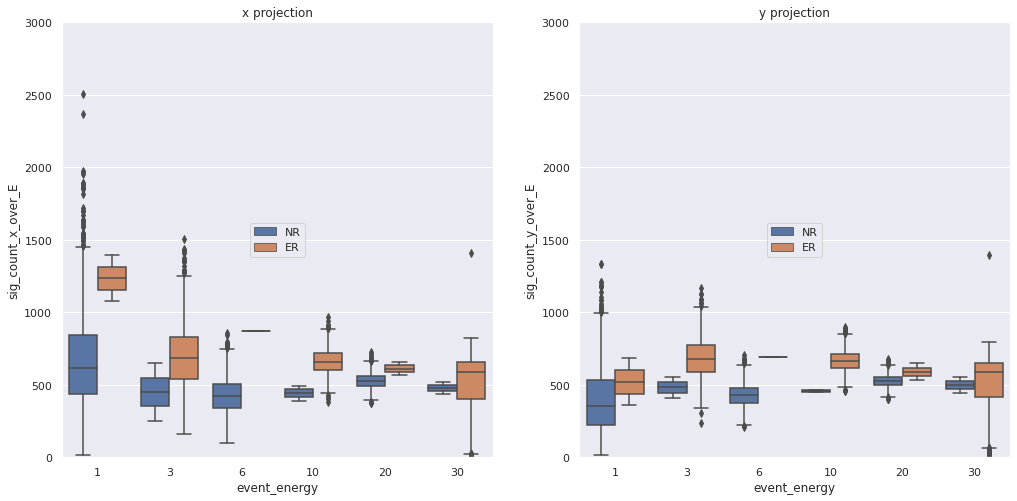

In [10]:
f, axes = plt.subplots(1, 2, figsize=(17,8))
for ax, proj in zip(axes, ['x', 'y']):
    ax.set_ylim(0, 3000)
    ax.set_title(f'{proj} projection')
    g = sns.boxplot(x='event_energy', y=f'sig_count_{proj}_over_E', hue='event_class', data=df.query(cut), ax=ax)
    g.legend(loc='center')

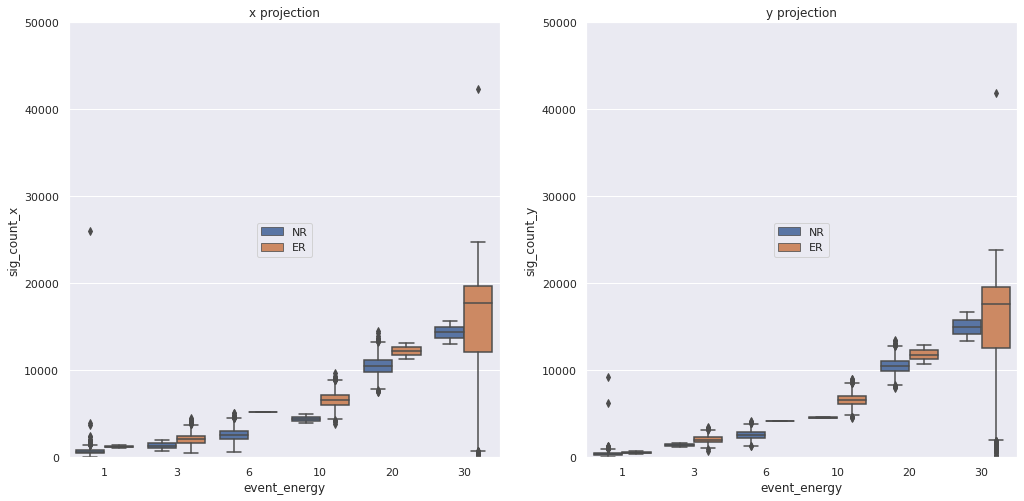

In [11]:
f, axes = plt.subplots(1, 2, figsize=(17,8))
for ax, proj in zip(axes, ['x', 'y']):
    ax.set_ylim(0, 50000)
    ax.set_title(f'{proj} projection')
    g = sns.boxplot(x='event_energy', y=f'sig_count_{proj}', hue='event_class', data=df.query(cut), ax=ax)
    g.legend(loc='center')

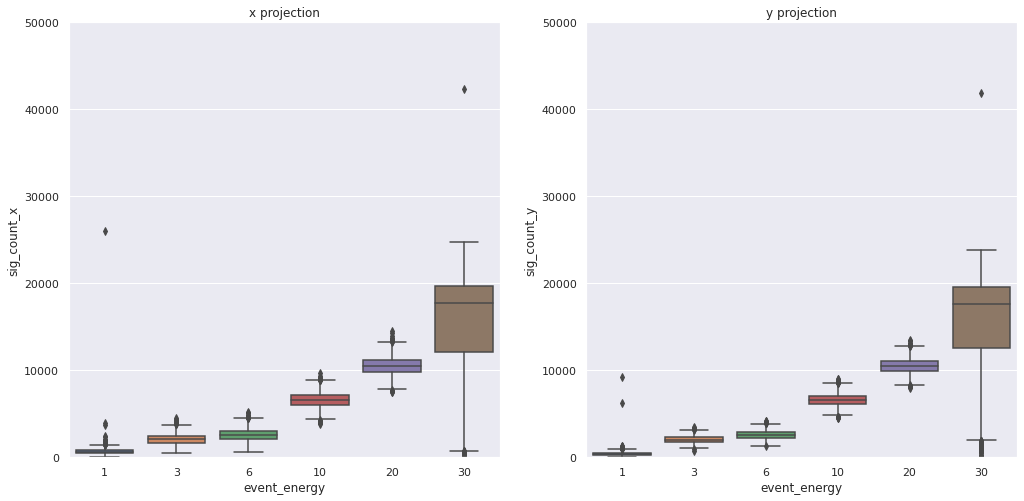

In [12]:
f, axes = plt.subplots(1, 2, figsize=(17,8))
for ax, proj in zip(axes, ['x', 'y']):
    ax.set_ylim(0, 50000)
    ax.set_title(f'{proj} projection')
    g = sns.boxplot(x='event_energy', y=f'sig_count_{proj}', data=df.query(cut), ax=ax)

### dev

In [13]:
cut

'sig_count_x > 0 and sig_count_x < 1.e5 and sig_count_y > 0 and sig_count_y < 1.e5 and fr_x > 1.e-5 and fr_y > 1.e-5 and sigma_x < 10 and sigma_y < 10'

In [14]:
bw_adjust = 0.3

In [15]:
# f, axes = plt.subplots(1, 2, figsize=(17,8))
# for ax, ec in zip(axes, ['NR', 'ER']):
#     ax.set_title(ec)
#     ax.set_xlim(0, 25000)
#     sns.kdeplot(df.query(cut + ' and event_energy == 1' + f'and event_class == "{ec}"').sig_count_x, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='1 keV')
#     sns.kdeplot(df.query(cut + ' and event_energy == 3' + f'and event_class == "{ec}"').sig_count_x, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='3 keV')
#     sns.kdeplot(df.query(cut + ' and event_energy == 6' + f'and event_class == "{ec}"').sig_count_x, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='6 keV')
#     sns.kdeplot(df.query(cut + ' and event_energy == 10' + f'and event_class == "{ec}"').sig_count_x, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='10 keV')
#     sns.kdeplot(df.query(cut + ' and event_energy == 20' + f'and event_class == "{ec}"').sig_count_x, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='20 keV')
#     sns.kdeplot(df.query(cut + ' and event_energy == 30' + f'and event_class == "{ec}"').sig_count_x, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='30 keV')
#     ax.legend()
# plt.show()

In [16]:
# f, axes = plt.subplots(1, 2, figsize=(17,8))
# for ax, ec in zip(axes, ['NR', 'ER']):
#     ax.set_title(ec)
#     ax.set_xlim(0, 25000)
#     sns.kdeplot(df.query(cut + ' and event_energy == 1' + f'and event_class == "{ec}"').sig_count_y, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='1 keV')
#     sns.kdeplot(df.query(cut + ' and event_energy == 3' + f'and event_class == "{ec}"').sig_count_y, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='3 keV')
#     sns.kdeplot(df.query(cut + ' and event_energy == 6' + f'and event_class == "{ec}"').sig_count_y, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='6 keV')
#     sns.kdeplot(df.query(cut + ' and event_energy == 10' + f'and event_class == "{ec}"').sig_count_y, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='10 keV')
#     sns.kdeplot(df.query(cut + ' and event_energy == 20' + f'and event_class == "{ec}"').sig_count_y, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='20 keV')
#     sns.kdeplot(df.query(cut + ' and event_energy == 30' + f'and event_class == "{ec}"').sig_count_y, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='30 keV')
#     ax.legend()
# plt.show()

In [17]:
# sns.kdeplot(df.query('event_energy == 1').sig_count_y, bw_adjust=bw_adjust, clip=(0, 25000), linewidth=3, label='1 keV')
# sns.kdeplot(df.query('event_energy == 3').sig_count_y, bw_adjust=bw_adjust, clip=(0, 25000), linewidth=3, label='3 keV')
# sns.kdeplot(df.query('event_energy == 6').sig_count_y, bw_adjust=bw_adjust, clip=(0, 25000), linewidth=3, label='6 keV')
# sns.kdeplot(df.query('event_energy == 10').sig_count_y, bw_adjust=bw_adjust, clip=(0, 25000), linewidth=3, label='10 keV')
# sns.kdeplot(df.query('event_energy == 20').sig_count_y, bw_adjust=bw_adjust, clip=(0, 25000), linewidth=3, label='20 keV')
# sns.kdeplot(df.query('event_energy == 30').sig_count_y, bw_adjust=2*bw_adjust, clip=(0, 25000), linewidth=3, label='30 keV')
# plt.vlines([1000, 4500, 8500], 0, 0.0015, 'grey', linestyles='dashed', linewidth=3)
# plt.legend()
# plt.show()

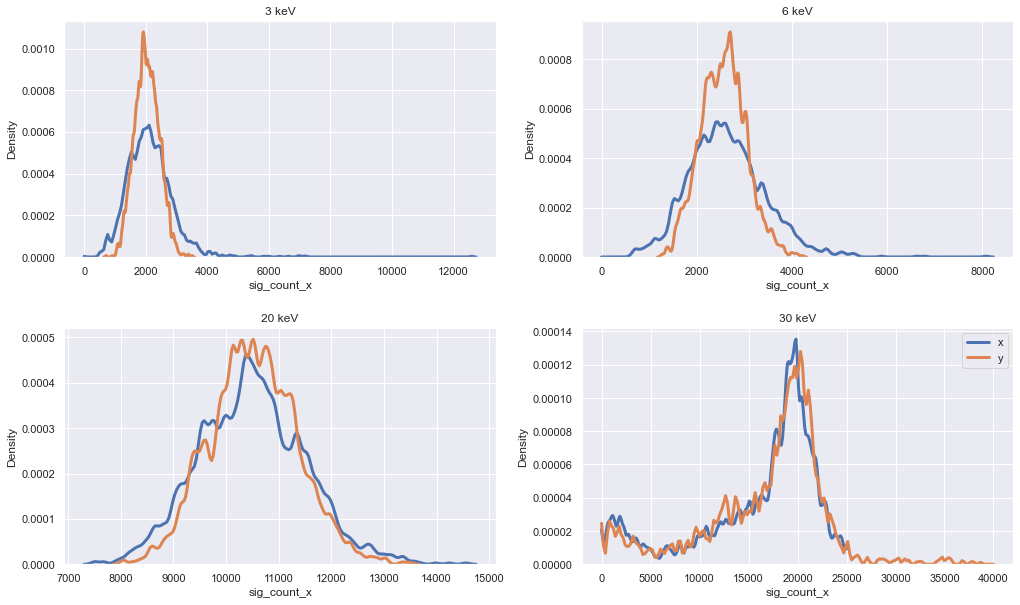

In [17]:
f, axes = plt.subplots(2, 2, figsize=(17,10))
f.subplots_adjust(hspace=0.3)
sns.kdeplot(df.query('event_energy == 3').sig_count_x, bw_adjust=bw_adjust, clip=(0, 25000), linewidth=3, label='x', ax=axes[0,0]); axes[0,0].set_title('3 keV'); 
sns.kdeplot(df.query('event_energy == 3').sig_count_y, bw_adjust=bw_adjust, clip=(0, 25000), linewidth=3, label='y', ax=axes[0,0])
sns.kdeplot(df.query('event_energy == 6').sig_count_x, bw_adjust=bw_adjust, clip=(0, 25000), linewidth=3, label='x', ax=axes[0,1]); axes[0,1].set_title('6 keV')
sns.kdeplot(df.query('event_energy == 6').sig_count_y, bw_adjust=bw_adjust, clip=(0, 25000), linewidth=3, label='y', ax=axes[0,1])
sns.kdeplot(df.query('event_energy == 20').sig_count_x, bw_adjust=bw_adjust, clip=(0, 25000), linewidth=3, label='x', ax=axes[1,0]); axes[1,0].set_title('20 keV')
sns.kdeplot(df.query('event_energy == 20').sig_count_y, bw_adjust=bw_adjust, clip=(0, 25000), linewidth=3, label='y', ax=axes[1,0])
sns.kdeplot(df.query('event_energy == 30').sig_count_x, bw_adjust=0.01*bw_adjust, clip=(0, 25000), linewidth=3, label='x', ax=axes[1,1]); axes[1,1].set_title('30 keV')
sns.kdeplot(df.query('event_energy == 30').sig_count_y, bw_adjust=0.01*bw_adjust, clip=(0, 40000), linewidth=3, label='y', ax=axes[1,1])
plt.legend()
plt.show()

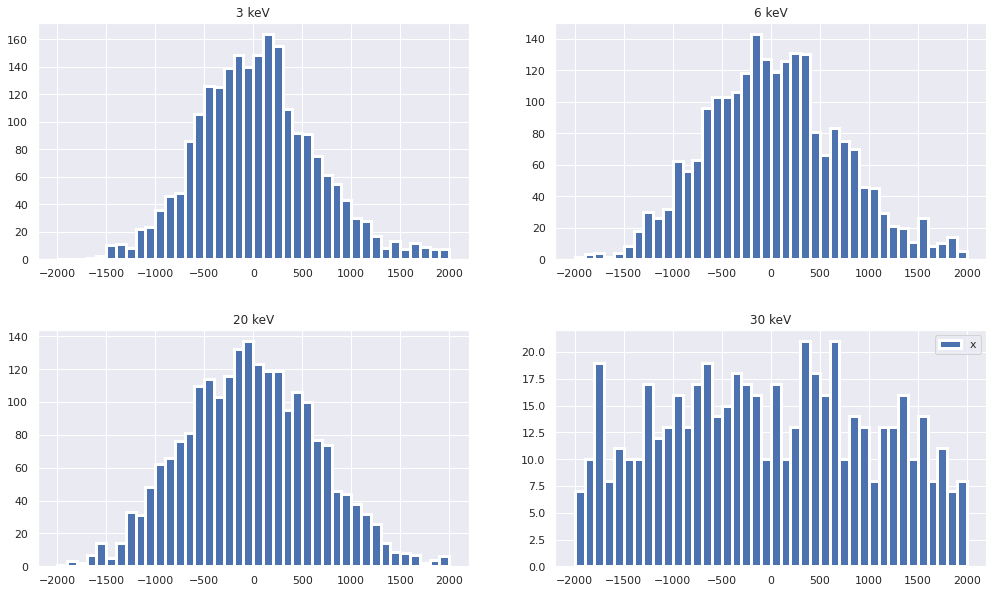

In [18]:
f, axes = plt.subplots(2, 2, figsize=(17,10))
f.subplots_adjust(hspace=0.3)
axes[0,0].hist(df.query('event_energy == 3').sig_count_x - df.query('event_energy == 3').sig_count_y, linewidth=3, label='x', bins=40, range=(-2000, 2000)); axes[0,0].set_title('3 keV'); 
axes[0,1].hist(df.query('event_energy == 6').sig_count_x - df.query('event_energy == 6').sig_count_y, linewidth=3, label='x', bins=40, range=(-2000, 2000)); axes[0,1].set_title('6 keV')
axes[1,0].hist(df.query('event_energy == 20').sig_count_x - df.query('event_energy == 20').sig_count_y, linewidth=3, label='x', bins=40, range=(-2000, 2000)); axes[1,0].set_title('20 keV')
axes[1,1].hist(df.query('event_energy == 30').sig_count_x - df.query('event_energy == 30').sig_count_y, linewidth=3, label='x', bins=40, range=(-2000, 2000)); axes[1,1].set_title('30 keV')
plt.legend()
plt.show()

* wiggly
* nothing
* normal gauss
* *ER 10 keV

### importanto

На графике выше при селективном подходе, мысль о котором возникла в чате (комбинация ... vs all + каты), я забыл про разные домены в трейне и тесте. Методика будет работать, если есть тождественность между ER<->NR по распределениям энергии. Это не так для энергии в 30 кэВ, где при замене ER<->NR качественно меняется поведение частицы данной энергии + аналогично для энергии 20 кэВ (но мб вероятность отлёта электрона становится меньше и события становятся чуть больше похожи на NR). Для энергии в 1кэВ я бы ожидал инвариантности (что там, что там ничего не видно среди плоского фона). В промежуточных энергиях есть ощущение, что пики и форма инвариантны при замене типа события, мб с небольшим сдвигом положения (см выше графики sig_count/E (E)). Мб попробовать вслепую потюнить пороги катов относительно трейновских и посмотреть как меняется скор на паблике

Итого, можно попробовать вот так (перебираются классы событий, ожидаемые в тесте): 
* 30 NR: детектить катом по sig_count, каким-то образом оценив положение пика и форму из 30 ER (например, взяв те 2.5 сэмпла из трейна или же глазами разметив парочку ярких событий в паблике😏)
* 20 ER: детектить через классификатор wiggly vs all. Можно потренить на 30 ER, выбрав фичи инвариантные к энергии (e.g. p-value фита)
* 10 NR: детектить катом по sig_count (см картинку серые линии). Здесь предполагаем инвариантость формы при ER<->NR замене (то есть что пик не съедет и не станет шире) - надо чекать
* 3 NR, 6 ER: хз, они перекрываются по энергии, поэтому мб натренить классификатор 3 vs 6 (тоже предположив инвариантность при замене доменов ER<->NR)
* 1 ER: хз, мб катом тоже порезать, или натренить классификатор "ничего не видно vs что-то видно"

### searching for wiggly

In [6]:
np.unique(df.event_energy, return_counts=True)

(array([ 1,  3,  6, 10, 20, 30]), array([2179, 2245, 2256, 2274, 2210, 2239]))

In [7]:
df.columns

Index(['N_bkgr_only_x', 'N_bkgr_only_y', 'N_error_bkgr_only_x',
       'N_error_bkgr_only_y', 'N_error_x', 'N_error_y', 'N_x', 'N_y',
       'bkgr_count_x', 'bkgr_count_y',
       ...
       'sigma_x', 'sigma_y', 'tolerance_bkgr_only_x', 'tolerance_bkgr_only_y',
       'tolerance_x', 'tolerance_y', 'up_bkgr_only_x', 'up_bkgr_only_y',
       'up_x', 'up_y'],
      dtype='object', length=116)

In [8]:
wiggly_vars = [
              'chi2_pvalue_x', 'chi2_pvalue_y', 
#                'chi2_x', 'chi2_y',
              'dfr', 
              'dmu', 'dsigma', 
              'sigma_x', 'sigma_y', 
#                'sigma_error_x', 'sigma_error_y', 
              'mu_x', 'mu_y', 
#                'mu_error_x', 'mu_error_y', 
       'n_excess_bins_x', 'n_excess_bins_y', 
#                'nfcn_total_x', 'nfcn_total_y',
#        'nfcn_x', 'nfcn_y', 'ngrad_total_x', 'ngrad_total_y', 'ngrad_x', 'ngrad_y', 
#                'sig_count_x', 'sig_count_y', 
#        'sig_density_x', 'sig_density_y', 
#                'dsig_count'
              ]

In [9]:
df_1 = df[df['event_energy'] == 1][:500]
df_3 = df[df['event_energy'] == 3][:500]
df_6 = df[df['event_energy'] == 6][:500]
df_10 = df[df['event_energy'] == 10][:500]
df_20 = df[df['event_energy'] == 20][:500]
df_20 = df_20.query('event_class != "ER"')
df_30 = df[df['event_energy'] == 30]
df_30 = df_30.query('event_class != "NR"')
df_w_vs_all = pd.concat([df_1,df_3,df_6,df_10,df_20,df_30])

In [10]:
# df_w_vs_all['sig_count_y_gr_8500'] = df_w_vs_all.sig_count_y > 8500
# df_public['sig_count_y_gr_8500'] = df_public.sig_count_y > 8500
# df_private['sig_count_y_gr_8500'] = df_private.sig_count_y > 8500

In [11]:
np.unique(df_w_vs_all.event_energy, return_counts=1)

(array([ 1,  3,  6, 10, 20, 30]), array([ 500,  500,  500,  500,  500, 2237]))

In [12]:
X = df_w_vs_all[wiggly_vars]
y = df_w_vs_all['event_energy'] == 30
np.bincount(y)

array([2500, 2237])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [14]:
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [15]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'max_depth': 4,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'early_stopping_rounds': 10
}

In [16]:
gbm = lgb.train(
                params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,  # eval training data
                verbose_eval=True,
#                 feature_name=X_train.columns,
#                 categorical_feature=[21]
               )

Found `early_stopping_rounds` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_logloss: 0.613332
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's binary_logloss: 0.550658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's binary_logloss: 0.498006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's binary_logloss: 0.45439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's binary_logloss: 0.416389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's binary_logloss: 0.383691
[LightGBM] [Warning] No fur

In [17]:
y_train_pred = gbm.predict(X_train)
y_test_pred = gbm.predict(X_test)

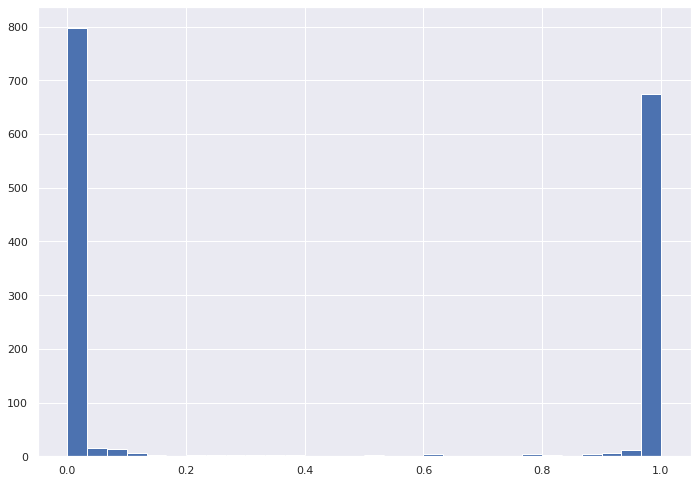

In [18]:
plt.hist(y_test_pred, bins=30)
plt.show()

In [19]:
roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_test_pred)

(1.0, 0.9987155452007724)

In [20]:
thr = 0.5
print(classification_report(y_test, y_test_pred > thr))

              precision    recall  f1-score   support

       False       0.99      0.99      0.99       853
        True       0.99      0.99      0.99       711

    accuracy                           0.99      1564
   macro avg       0.99      0.99      0.99      1564
weighted avg       0.99      0.99      0.99      1564



### test on private samples in train

* by eye, they are clearly wiggly, so expect high proba there

In [21]:
df_ER[df_ER.event_energy == 20]

N_bkgr_only_x  N_bkgr_only_y  N_error_bkgr_only_x  N_error_bkgr_only_y  \
88     1.459844e+06   1.459781e+06          1208.240082          1208.213869   
1935   1.455492e+06   1.455429e+06          1206.437822          1206.411432   

        N_error_x    N_error_y           N_x           N_y  bkgr_count_x  \
88    1208.377341  1208.416193  1.460170e+06  1.460270e+06  1.447035e+06   
1935  1206.541136  1206.582449  1.455741e+06  1.455841e+06  1.444382e+06   

      bkgr_count_y  ...    sigma_x   sigma_y  tolerance_bkgr_only_x  \
88    1.447318e+06  ...   8.892997  6.241519                    0.1   
1935  1.445163e+06  ...   8.746008  5.217660                    0.1   

      tolerance_bkgr_only_y  tolerance_x  tolerance_y  up_bkgr_only_x  \
88                      0.1          0.1          0.1             1.0   
1935                    0.1          0.1          0.1             1.0   

      up_bkgr_only_y  up_x  up_y  
88               1.0   1.0   1.0  
1935             1.0   1.0   1.0  

[2 rows x 116 columns]

In [22]:
gbm.predict(df.query('event_energy == 20 and event_class == "ER"')[wiggly_vars])

array([0.99798165, 0.98146324])

### check for various rand seeds

In [32]:
df_1 = df[df['event_energy'] == 1][:500]
df_3 = df[df['event_energy'] == 3][:500]
df_6 = df[df['event_energy'] == 6][:500]
df_10 = df[df['event_energy'] == 10][:500]
df_20 = df[df['event_energy'] == 20][:500]
df_20 = df_20.query('event_class != "ER"')
df_30 = df[df['event_energy'] == 30]
df_30 = df_30.query('event_class != "NR"')
df_w_vs_all = pd.concat([df_1,df_3,df_6,df_10,df_20,df_30])


ER_predict = []
NR_predict = []
evl = []

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'max_depth': 4,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'early_stopping_rounds': 10
}

wiggly_vars = [
              'chi2_pvalue_x', 'chi2_pvalue_y', 
#                'chi2_x', 'chi2_y',
              'dfr', 
              'dmu', 'dsigma', 
              'sigma_x', 'sigma_y', 
#                'sigma_error_x', 'sigma_error_y', 
              'mu_x', 'mu_y', 
#                'mu_error_x', 'mu_error_y', 
       'n_excess_bins_x', 'n_excess_bins_y', 
#                'nfcn_total_x', 'nfcn_total_y',
#        'nfcn_x', 'nfcn_y', 'ngrad_total_x', 'ngrad_total_y', 'ngrad_x', 'ngrad_y', 
#                'sig_count_x', 'sig_count_y', 
#        'sig_density_x', 'sig_density_y', 
#                'dsig_count'
              ]

X = df_w_vs_all[wiggly_vars]
y = df_w_vs_all['event_energy'] == 30

for rand_seed in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rand_seed)
    
    lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
#     lgb_train = lgb.Dataset(X, y, free_raw_data=False)
#     lgb_eval = lgb.Dataset(X, y, reference=lgb_train)
    
    clf = lgb.train(
                params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,  # eval training data
                verbose_eval=-1,
#                 feature_name=X_train.columns,
#                 categorical_feature=[21]
               )

    ER_predict.append(clf.predict(df.query('event_energy == 20 and event_class == "ER"')[wiggly_vars]))
    NR_predict.append(clf.predict(df.query('event_energy == 30 and event_class == "NR"')[wiggly_vars]))
    
    y_test_pred = clf.predict(X_test)
    evl.append(roc_auc_score(y_test, y_test_pred))

Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[95]	valid_0's binary_logloss: 0.0376947
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.0307674
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.0576646
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.0290251
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 0.0274014


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.0381183
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[96]	valid_0's binary_logloss: 0.0307745


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.0228128
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[102]	valid_0's binary_logloss: 0.0468728
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.0269844
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.0256242
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.029945
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.0294404
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[106]	valid_0's binary_logloss: 0.0293487
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.024695
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.0365478
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[137]	valid_0's binary_logloss: 0.0243515
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[131]	valid_0's binary_logloss: 0.0259426
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.0276012
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[130]	valid_0's binary_logloss: 0.0312444


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.0352317
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[99]	valid_0's binary_logloss: 0.0354973


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[107]	valid_0's binary_logloss: 0.0258231
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[112]	valid_0's binary_logloss: 0.0313666
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[110]	valid_0's binary_logloss: 0.0361799
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[94]	valid_0's binary_logloss: 0.0400126
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.0320067


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.0248313
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[130]	valid_0's binary_logloss: 0.0328787
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[133]	valid_0's binary_logloss: 0.022061
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[152]	valid_0's binary_logloss: 0.0280416
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.0432162
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[82]	valid_0's binary_logloss: 0.0291848
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[100]	valid_0's binary_logloss: 0.0270058
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.0336292
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.0271122
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[121]	valid_0's binary_logloss: 0.0299666
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.034137
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[104]	valid_0's binary_logloss: 0.0285131
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[119]	valid_0's binary_logloss: 0.0417249
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.026311
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[131]	valid_0's binary_logloss: 0.0302713
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.0345177
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[138]	valid_0's binary_logloss: 0.0342049
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.0240923
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[95]	valid_0's binary_logloss: 0.037882
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[94]	valid_0's binary_logloss: 0.0375826
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[118]	valid_0's binary_logloss: 0.0325179
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[99]	valid_0's binary_logloss: 0.0290979
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[123]	valid_0's binary_logloss: 0.0345084
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[126]	valid_0's binary_logloss: 0.0261849
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.0166952


Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[121]	valid_0's binary_logloss: 0.0331991


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[99]	valid_0's binary_logloss: 0.0293528
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.0262629
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.0384019
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.0371959
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[119]	valid_0's binary_logloss: 0.0284542


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[84]	valid_0's binary_logloss: 0.0321844
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[132]	valid_0's binary_logloss: 0.0369128
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[136]	valid_0's binary_logloss: 0.0371107
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.0358762
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[111]	valid_0's binary_logloss: 0.0294537
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[110]	valid_0's binary_logloss: 0.0351
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.0275915
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[131]	valid_0's binary_logloss: 0.0194895
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.0511269
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[116]	valid_0's binary_logloss: 0.0249421
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[111]	valid_0's binary_logloss: 0.0271628
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[135]	valid_0's binary_logloss: 0.0245392
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.0349644
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[99]	valid_0's binary_logloss: 0.0363801
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.0412233
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[107]	valid_0's binary_logloss: 0.038697
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.0257295
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[117]	valid_0's binary_logloss: 0.0346752
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.0365162
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[118]	valid_0's binary_logloss: 0.0236325
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[93]	valid_0's binary_logloss: 0.0351407
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[117]	valid_0's binary_logloss: 0.0284332
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.0572019
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.0270295
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[147]	valid_0's binary_logloss: 0.017637
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.0361798
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.0327218
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[114]	valid_0's binary_logloss: 0.0316522
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[103]	valid_0's binary_logloss: 0.0366153
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.028333
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[139]	valid_0's binary_logloss: 0.0302311
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.0393891
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[123]	valid_0's binary_logloss: 0.0283471
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.0248653
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[118]	valid_0's binary_logloss: 0.0387092
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[102]	valid_0's binary_logloss: 0.0366769
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.049335
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[155]	valid_0's binary_logloss: 0.0233588


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[148]	valid_0's binary_logloss: 0.0281164
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.0314319
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.0313419
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.0407041


Found `early_stopping_rounds` in params. Will use it instead of argument


(0.0, 1.0)

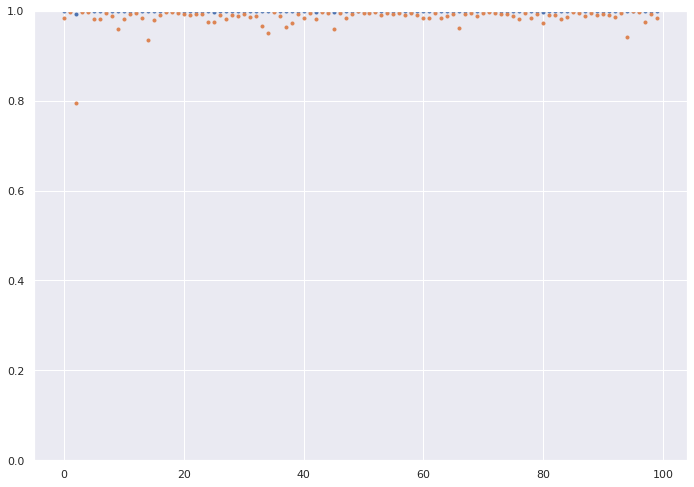

In [33]:
plt.plot(ER_predict, '.')
plt.ylim([0,1])

(0.0, 1.0)

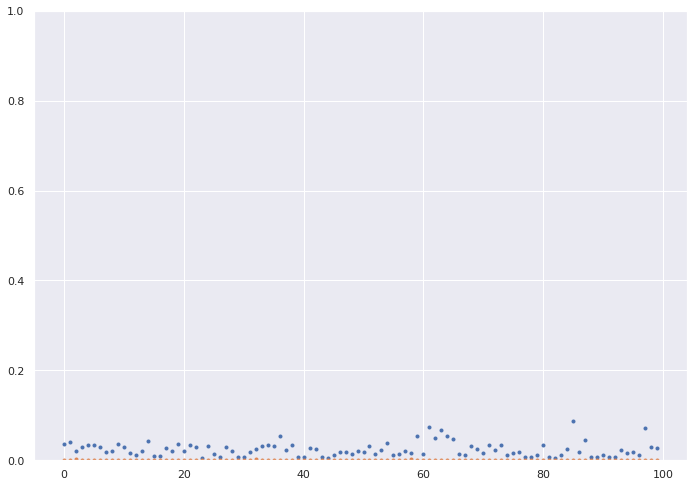

In [34]:
plt.plot(NR_predict, '.')
plt.ylim([0,1])

### test it on public

In [36]:
y_public_pred = gbm.predict(df_public[wiggly_vars])
y_private_pred = gbm.predict(df_private[wiggly_vars])

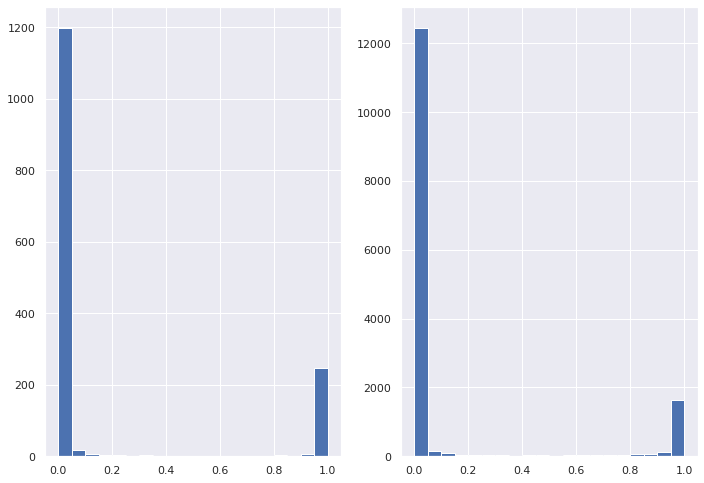

In [37]:
fig, axs = plt.subplots(1, 2)
axs[0].hist(y_public_pred, bins=20)
axs[1].hist(y_private_pred, bins=20)
plt.show()

In [38]:
sum(y_public_pred > 0.5), sum(y_private_pred > 0.3)

(266, 2228)

* maybe by hand put negative sum counts somewhere? 

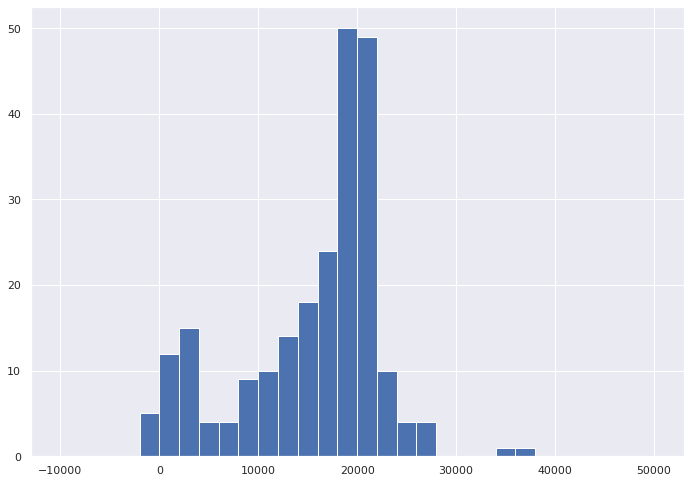

In [39]:
plt.hist(df_public[y_public_pred > 0.9].sig_count_y, bins=30, range=(-10000, 50000))
plt.show()

In [40]:
thr = 0.5

In [41]:
public_wiggly_pred = df_public.image_name[y_public_pred > thr].values
private_wiggly_pred = df_private.image_name[y_private_pred > thr].values

In [42]:
with open(f'wiggly_public_{thr}.txt', 'w') as f:
    f.write('\n'.join(public_wiggly_pred))

In [43]:
with open(f'wiggly_private_{thr}.txt', 'w') as f:
    f.write('\n'.join(private_wiggly_pred))

### interpret

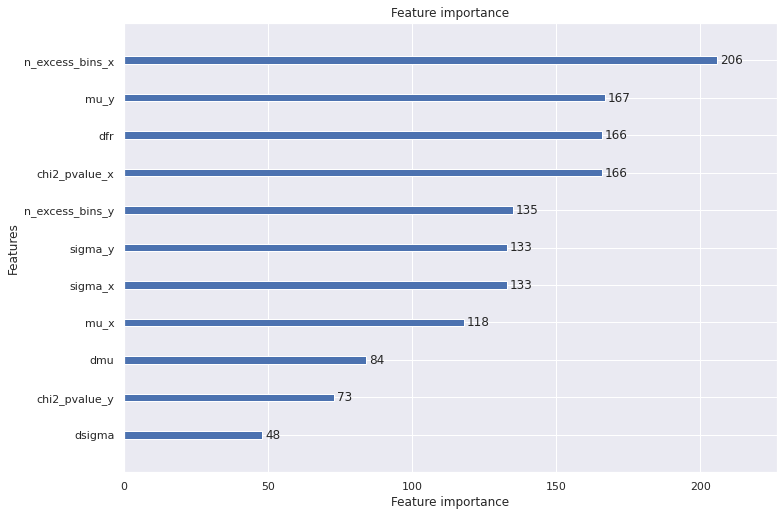

In [42]:
lgb.plot_importance(gbm)
plt.show()

In [43]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


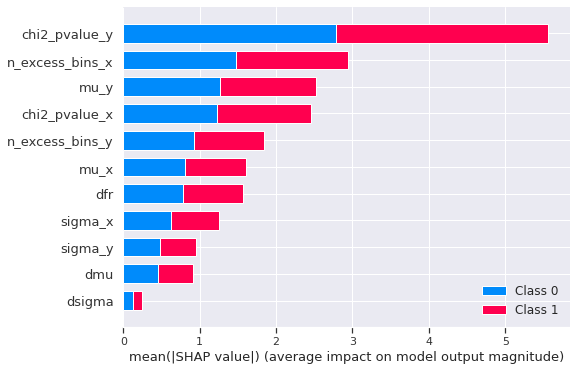

In [44]:
shap.summary_plot(shap_values, X)

### regressor

#### sig_count studies

In [45]:
# is sig_count resolution the same for diff. E?

In [46]:
sc_3_y = df.query('event_energy == 3').sig_count_y
sc_6_y = df.query('event_energy == 6').sig_count_y
sc_10_y = df.query('event_energy == 10').sig_count_y
sc_20_y = df.query('event_energy == 20').sig_count_y
#
sc_3_x = df.query('event_energy == 3').sig_count_x
sc_6_x = df.query('event_energy == 6').sig_count_x
sc_10_x = df.query('event_energy == 10').sig_count_x
sc_20_x = df.query('event_energy == 20').sig_count_x

In [47]:
sc_means = [np.mean(sc_3_y), np.mean(sc_6_y), np.mean(sc_10_y), np.mean(sc_20_y)]
sc_stds = [np.std(sc_3_y), np.std(sc_6_y), np.std(sc_10_y), np.std(sc_20_y)]
sc_energies = [3, 6, 10, 20]

In [48]:
sc_3_y -= np.mean(sc_3_y)
sc_6_y -= np.mean(sc_6_y)
sc_10_y -= np.mean(sc_10_y)
sc_20_y -= np.mean(sc_20_y)
#
sc_3_x -= np.mean(sc_3_x)
sc_6_x -= np.mean(sc_6_x)
sc_10_x -= np.mean(sc_10_x)
sc_20_x -= np.mean(sc_20_x)

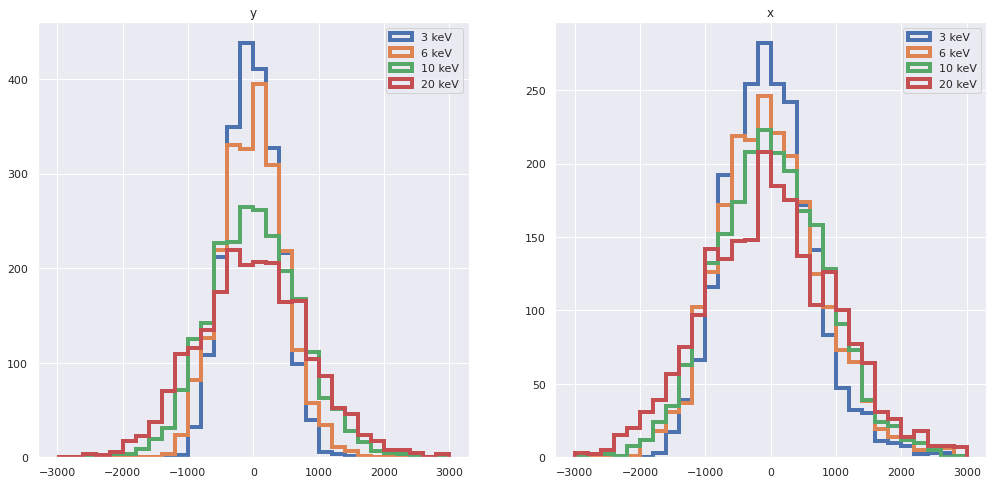

In [49]:
fig, axs = plt.subplots(1,2, figsize=(17,8))
axs[0].hist(sc_3_y, bins=30, histtype='step', linewidth=4, range=(-3000, 3000), label='3 keV')
axs[0].hist(sc_6_y, bins=30, histtype='step', linewidth=4, range=(-3000, 3000), label='6 keV')
axs[0].hist(sc_10_y, bins=30, histtype='step', linewidth=4, range=(-3000, 3000), label='10 keV')
axs[0].hist(sc_20_y, bins=30, histtype='step', linewidth=4, range=(-3000, 3000), label='20 keV')
axs[0].set_title('y')
axs[0].legend()
#
axs[1].hist(sc_3_x, bins=30, histtype='step', linewidth=4, range=(-3000, 3000), label='3 keV')
axs[1].hist(sc_6_x, bins=30, histtype='step', linewidth=4, range=(-3000, 3000), label='6 keV')
axs[1].hist(sc_10_x, bins=30, histtype='step', linewidth=4, range=(-3000, 3000), label='10 keV')
axs[1].hist(sc_20_x, bins=30, histtype='step', linewidth=4, range=(-3000, 3000), label='20 keV')
axs[1].set_title('x')
axs[1].legend()
plt.show()

#### extrapolate mean and std

In [50]:
a_mean, b_mean = np.polyfit(sc_energies, sc_means, deg=1)
a_std, b_std = np.polyfit(sc_energies, sc_stds, deg=1)

In [51]:
mean_30, std_30 = a_mean*30+b_mean, a_std*30+b_std, 
mean_30, std_30 

(16017.213016092775, 1145.5906357630997)

In [52]:
# generate synthetic data
sc_30_synth = np.random.normal(loc=mean_30, scale=std_30, size=2000)

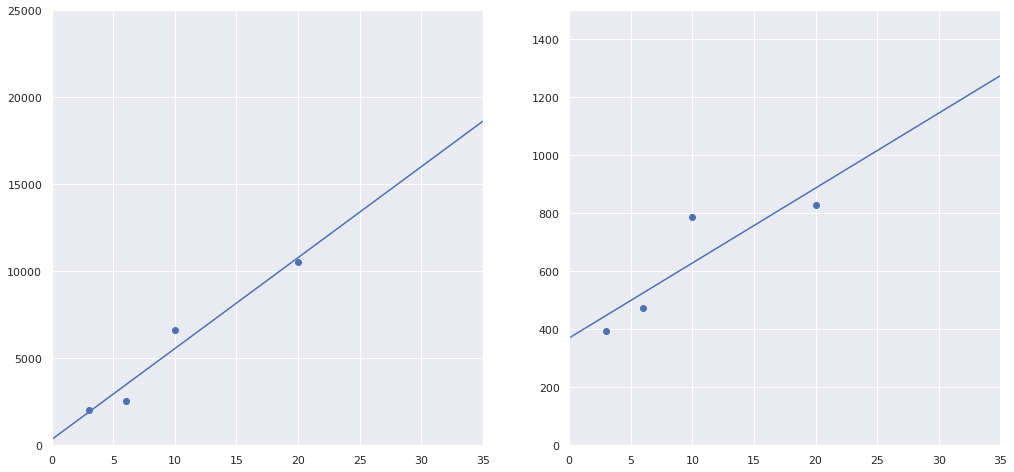

In [53]:
fig, axs = plt.subplots(1,2, figsize=(17,8))
axs[0].scatter(sc_energies, sc_means)
axs[0].plot([0, 40], a_mean*np.array([0, 40])+b_mean)
axs[1].scatter(sc_energies, sc_stds)
axs[1].plot([0, 40], a_std*np.array([0, 40])+b_std)
axs[0].set_xlim(0, 35)
axs[1].set_xlim(0, 35)
axs[0].set_ylim(0, 25000)
axs[1].set_ylim(0, 1500)
plt.show()

#### fit inclusively 

In [54]:
X = df.query('event_energy > 1 and event_energy < 30').sig_count_y
y = df.query('event_energy > 1 and event_energy < 30').event_energy

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# X_train = X_train.values.reshape(-1, 1)
# X_test = X_test.values.reshape(-1, 1)
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

In [56]:
regr = SGDRegressor(loss='squared_loss', penalty='l2', alpha=.01, 
                    max_iter=1000, early_stopping=True, validation_fraction=0.1, n_iter_no_change=10)

In [57]:
# regr.fit(X_train, y_train)
regr.fit(y_train, X_train)

SGDRegressor(alpha=0.01, average=False, early_stopping=True, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=10, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

(array([735., 740.,   0.,   0., 755.,   0.,   0.,   0.,   0., 736.]),
 array([ 1917.29941333,  2818.51829608,  3719.73717883,  4620.95606158,
         5522.17494433,  6423.39382708,  7324.61270983,  8225.83159258,
         9127.05047533, 10028.26935808, 10929.48824083]),
 <BarContainer object of 10 artists>)

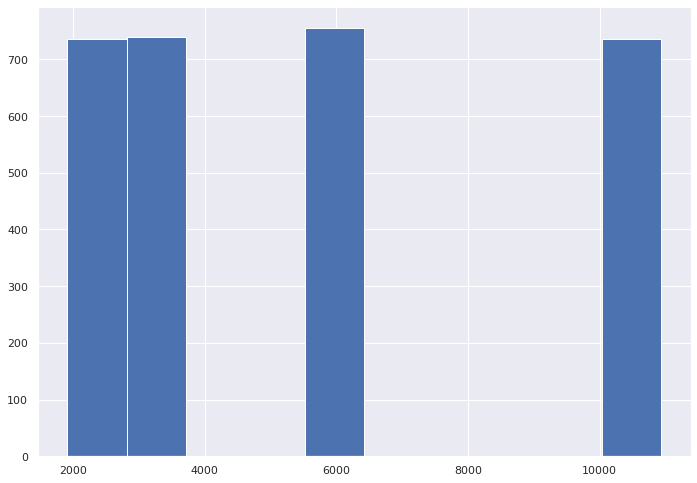

In [58]:
plt.hist(regr.predict(y_test))

In [59]:
regr.coef_, regr.intercept_

(array([530.12875456]), array([326.91314966]))

sc = coef_*E + intercept_   
E = (sc - intercept_)/coef_

In [60]:
def invert_regr(regr, y):
    x = (y - regr.intercept_)/regr.coef_
    return x

In [61]:
sc = df.query('event_energy < 30').sig_count_y
E_true = df.query('event_energy < 30').event_energy

In [62]:
E_pred = invert_regr(regr, sc)
E_pred_30_synth = invert_regr(regr, sc_30_synth)

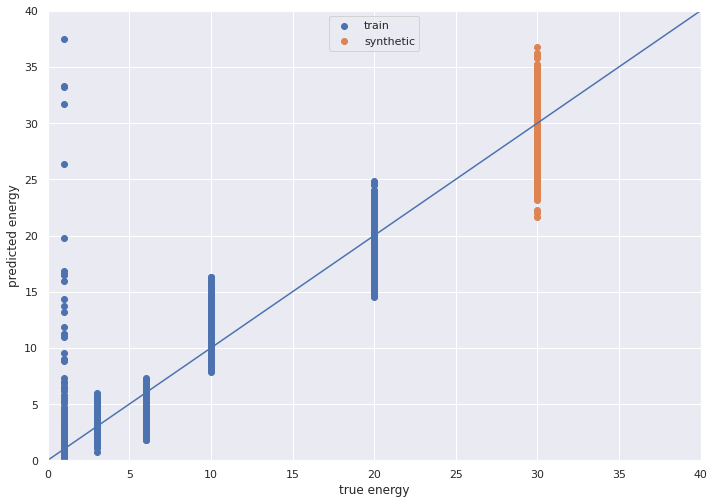

In [63]:
xmin, xmax = 0, 40
plt.scatter(E_true, E_pred, label='train')
plt.scatter(30*np.ones_like(E_pred_30_synth), E_pred_30_synth, label='synthetic')
plt.plot([xmin,xmax], [xmin,xmax])
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
plt.xlabel('true energy')
plt.ylabel('predicted energy')
plt.legend(loc='upper center')
plt.show()

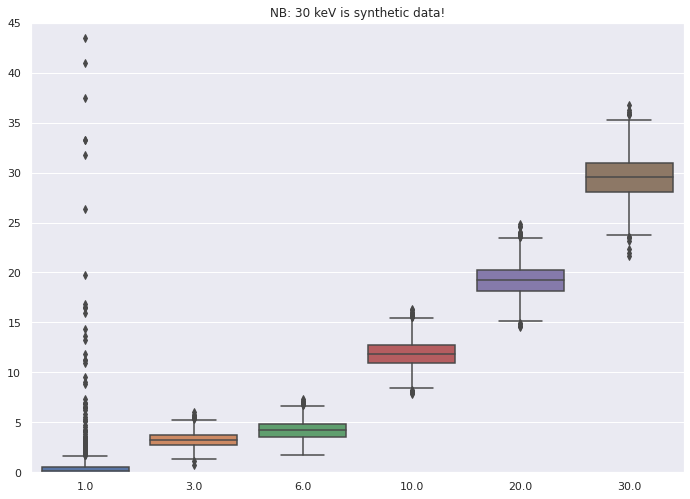

In [64]:
plt.ylim(0, 45)
plt.title("NB: 30 keV is synthetic data!")
sns.boxplot(x=np.concatenate([E_true, 30*np.ones_like(E_pred_30_synth),]), y=np.concatenate([E_pred, E_pred_30_synth]))
plt.show()

#### fit exclusively for ER/NR

In [65]:
X_ER = df.query('event_energy > 1 and event_energy < 30 and event_class == "ER"').sig_count_y
y_ER = df.query('event_energy > 1 and event_energy < 30 and event_class == "ER"').event_energy

X_NR = df.query('event_energy > 1 and event_energy < 30 and event_class == "NR"').sig_count_y
y_NR = df.query('event_energy > 1 and event_energy < 30 and event_class == "NR"').event_energy

In [66]:
X_ER_train, X_ER_test, y_ER_train, y_ER_test = train_test_split(X_ER, y_ER, test_size=0.33, random_state=42)
X_NR_train, X_NR_test, y_NR_train, y_NR_test = train_test_split(X_NR, y_NR, test_size=0.33, random_state=42)
#
y_ER_train = y_ER_train.values.reshape(-1, 1)
y_ER_test = y_ER_test.values.reshape(-1, 1)
y_NR_train = y_NR_train.values.reshape(-1, 1)
y_NR_test = y_NR_test.values.reshape(-1, 1)

In [67]:
regr_ER = SGDRegressor(loss='squared_loss', penalty='l2', alpha=.01, 
                    max_iter=1000, early_stopping=True, validation_fraction=0.1, n_iter_no_change=10)
regr_NR = SGDRegressor(loss='squared_loss', penalty='l2', alpha=.01, 
                    max_iter=1000, early_stopping=True, validation_fraction=0.1, n_iter_no_change=10)

In [68]:
regr_ER.fit(y_ER_train, X_ER_train)
regr_NR.fit(y_NR_train, X_NR_train)

SGDRegressor(alpha=0.01, average=False, early_stopping=True, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=10, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [69]:
regr_ER.coef_, regr_ER.intercept_

(array([656.55217436]), array([98.59351176]))

In [70]:
regr_NR.coef_, regr_NR.intercept_

(array([578.09546765]), array([-849.65853355]))

In [71]:
regr_ER.predict([[1], [6]]) # expect in test

array([ 755.14568613, 4037.90655795])

In [72]:
regr_NR.predict([[3], [10]]) # expect in test

array([ 884.62786942, 4931.296143  ])

sc = coef_*E + intercept_   
E = (sc - intercept_)/coef_

In [73]:
sc = df.query('event_energy < 30').sig_count_y
E_true = df.query('event_energy < 30').event_energy

In [74]:
E_pred = invert_regr(regr, sc)
E_pred_30_synth = invert_regr(regr, sc_30_synth)

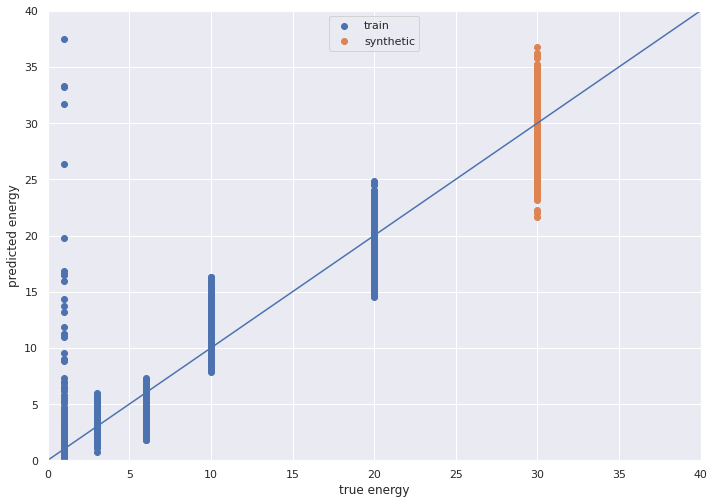

In [75]:
xmin, xmax = 0, 40
plt.scatter(E_true, E_pred, label='train')
plt.scatter(30*np.ones_like(E_pred_30_synth), E_pred_30_synth, label='synthetic')
plt.plot([xmin,xmax], [xmin,xmax])
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
plt.xlabel('true energy')
plt.ylabel('predicted energy')
plt.legend(loc='upper center')
plt.show()

### hacking private

In [76]:
sc_private = df_private.sig_count_y
E_pred_private = invert_regr(regr, sc_private)
min(E_pred_private), max(E_pred_private)

(-143.38390509962326, 942.7892624853539)

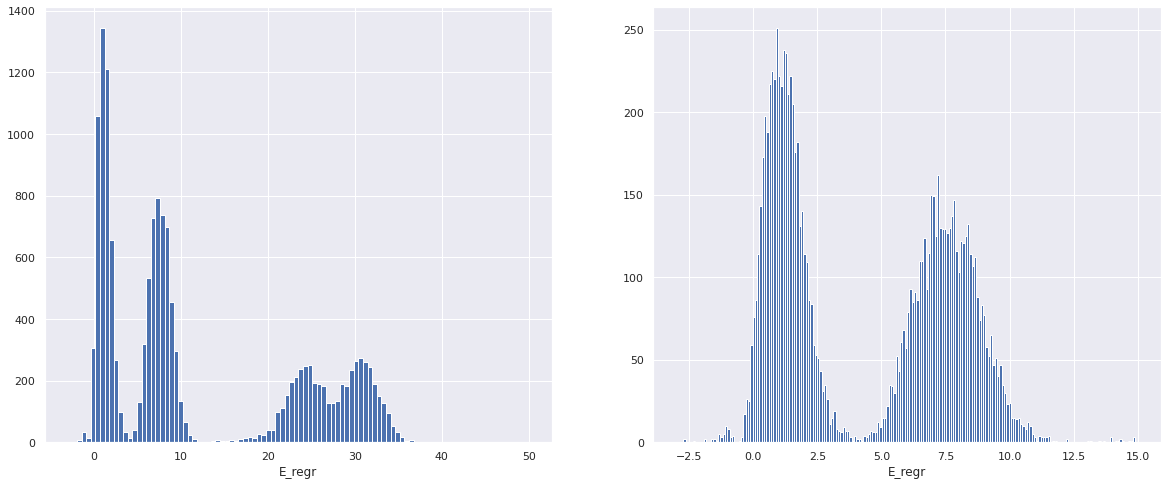

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].hist(E_pred_private, bins=100, range=(-3, 50))
axs[0].set_xlabel('E_regr')
axs[1].hist(E_pred_private, bins=200, range=(-3, 15))
axs[1].set_xlabel('E_regr')
plt.show()

In [78]:
sum(~((E_pred_private > 0) & (E_pred_private < 50))), E_pred_private.shape

(239, (15058,))

In [79]:
sum(((E_pred_private > 4) & (E_pred_private < 12)))

4977

In [80]:
sum(E_pred_private < 4)

5059

In [81]:
sum((E_pred_private > 26) & (E_pred_private < 40))

2952

In [82]:
sum(E_pred_private < 0)

229

#### remove wiggly

In [83]:
y_private_pred = gbm.predict(df_private[wiggly_vars])

In [84]:
thr = 0.05
sc_private_nw = df_private[y_private_pred<thr].sig_count_y
sc_private_w = df_private[y_private_pred>=thr].sig_count_y
E_pred_private_nw = invert_regr(regr, sc_private_nw)
E_pred_private_w = invert_regr(regr, sc_private_w)
min(E_pred_private_nw), max(E_pred_private_nw)

(-143.38390509962326, 115.09790239027183)

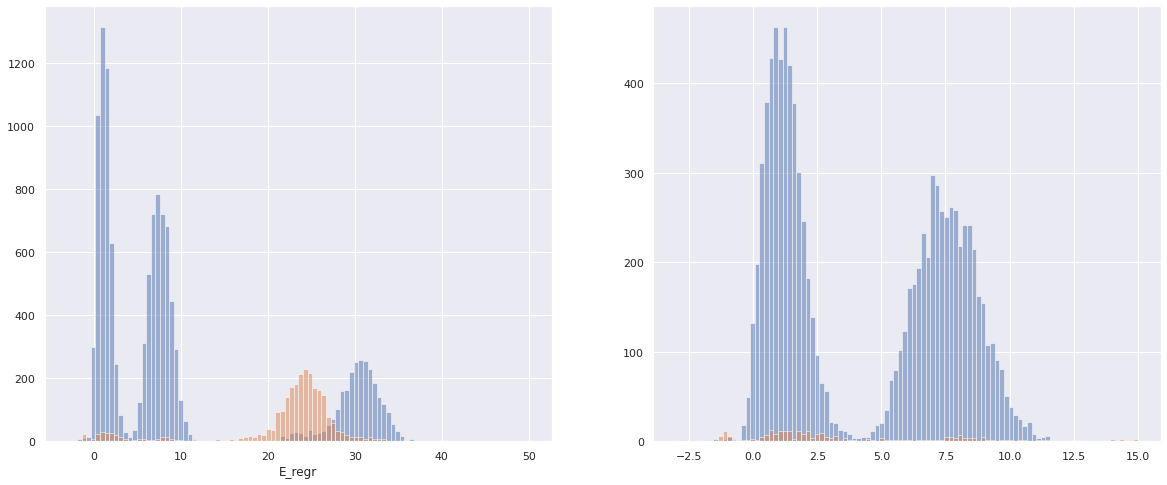

In [85]:
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].hist(E_pred_private_nw, bins=100, range=(-3, 50), alpha=0.5)
axs[0].hist(E_pred_private_w, bins=100, range=(-3, 50), alpha=0.5)
axs[0].set_xlabel('E_regr')
axs[1].hist(E_pred_private_nw, bins=100, range=(-3, 15), alpha=0.5)
axs[1].hist(E_pred_private_w, bins=100, range=(-3, 15), alpha=0.5)
axs[0].set_xlabel('E_regr')
plt.show()

In [86]:
sum(y_private_pred > 0.05)

2619

### domain difference

In [87]:
sc_train_1_3 = df.query('event_energy>=1 and event_energy<=3').sig_count_y
sc_train_6_10 = df.query('event_energy>=6 and event_energy<=10').sig_count_y
sc_train_20_30 = df.query('event_energy>=20 and event_energy<=30').sig_count_y
E_pred_train_1_3 = invert_regr(regr, sc_train_1_3)
E_pred_train_6_10 = invert_regr(regr, sc_train_6_10)
E_pred_train_20_30 = invert_regr(regr, sc_train_20_30)
E_pred_public = invert_regr(regr, df_public.sig_count_y)
E_pred_private = invert_regr(regr, df_private.sig_count_y)
min(E_pred_train_1_3), max(E_pred_train_1_3)

(-425.5270298072892, 254.39799829065328)

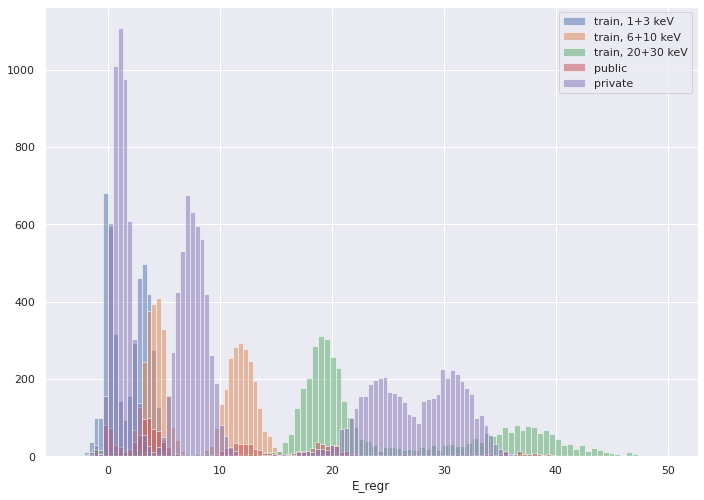

In [88]:
# fig, axs = plt.subplots(1, 2, figsize=(20,8))
plt.hist(E_pred_train_1_3, bins=100, range=(-3, 40), alpha=0.5, label='train, 1+3 keV')
plt.hist(E_pred_train_6_10, bins=100, range=(-3, 40), alpha=0.5, label='train, 6+10 keV')
plt.hist(E_pred_train_20_30, bins=100, range=(-3, 50), alpha=0.5, label='train, 20+30 keV')
plt.hist(E_pred_public, bins=100, range=(-3, 40), alpha=0.5, label='public')
plt.hist(E_pred_private, bins=100, range=(-3, 40), alpha=0.5, label='private')
plt.xlabel('E_regr')
# axs[1].hist(E_pred_private_nw, bins=100, range=(-3, 20), alpha=0.5)
plt.legend()
plt.show()

#### predict on test domain in train

In [89]:
df.query('event_energy == 6 and event_class == "ER"')

N_bkgr_only_x  N_bkgr_only_y  N_error_bkgr_only_x  N_error_bkgr_only_y  \
2950   1.450287e+06   1.450417e+06          1204.278505          1204.332587   

        N_error_x    N_error_y           N_x           N_y  bkgr_count_x  \
2950  1204.317146  1204.363644  1.450380e+06  1.450492e+06  1.445151e+06   

      bkgr_count_y         ...          tolerance_bkgr_only_x  \
2950  1.446360e+06         ...                            0.1   

      tolerance_bkgr_only_y  tolerance_x  tolerance_y  up_bkgr_only_x  \
2950                    0.1          0.1          0.1             1.0   

      up_bkgr_only_y  up_x  up_y  sig_count_x_over_E  sig_count_y_over_E  
2950             1.0   1.0   1.0          871.449758          688.616644  

[1 rows x 118 columns]

In [97]:
invert_regr(regr, df.query('event_energy == 6 and event_class == "ER"').sig_count_y)

2950    7.336946
Name: sig_count_y, dtype: float64

In [98]:
invert_regr(regr, df.query('event_energy == 10 and event_class == "NR"').sig_count_y)

2586    8.348806
3573    7.998868
Name: sig_count_y, dtype: float64

In [99]:
invert_regr(regr, df.query('event_energy == 3 and event_class == "NR"').sig_count_y)

5442    2.564624
5684    1.720233
Name: sig_count_y, dtype: float64

In [100]:
invert_regr(regr, df.query('event_energy == 1 and event_class == "ER"').sig_count_y)

359     0.669226
3691    4.297237
4162    0.043374
Name: sig_count_y, dtype: float64

### separate 6 vs 10 

In [6]:
df.columns

Index(['N_bkgr_only_x', 'N_bkgr_only_y', 'N_error_bkgr_only_x',
       'N_error_bkgr_only_y', 'N_error_x', 'N_error_y', 'N_x', 'N_y',
       'bkgr_count_x', 'bkgr_count_y',
       ...
       'tolerance_bkgr_only_x', 'tolerance_bkgr_only_y', 'tolerance_x',
       'tolerance_y', 'up_bkgr_only_x', 'up_bkgr_only_y', 'up_x', 'up_y',
       'sig_count_x_over_E', 'sig_count_y_over_E'],
      dtype='object', length=118)

In [7]:
clf_vars = [
#               'chi2_pvalue_x', 'chi2_pvalue_y', 
#                'chi2_x', 'chi2_y',
              'dfr', 
              'dmu', 'dsigma', 
#               'fr_error_x', 'fr_error_y', 'fr_x', 'fr_y',
              'sigma_x', 'sigma_y', 
#               'sigma_error_x', 'sigma_error_y', 
              'mu_x', 'mu_y', 
#               'mu_error_x', 'mu_error_y', 
              'n_excess_bins_x', 'n_excess_bins_y', 
#                'nfcn_total_x', 'nfcn_total_y',
#        'nfcn_x', 'nfcn_y', 'ngrad_total_x', 'ngrad_total_y', 'ngrad_x', 'ngrad_y', 
              'sig_count_x', 'sig_count_y', 
              'sig_density_x', 'sig_density_y', 
#                'dsig_count'
              ]

In [70]:
df_10.shape

(2274, 118)

In [73]:
# df_1 = df[df['event_energy'] == 1][:500]
# df_3 = df[df['event_energy'] == 3][:500]
df_6 = df[df['event_energy'] == 6]
df_6 = df_6.query('event_class != "ER"')
df_10 = df[df['event_energy'] == 10]
df_10 = df_10.query('event_class != "NR"')
# df_20 = df[df['event_energy'] == 20][:500]
# df_30 = df[df['event_energy'] == 30]
df_6_vs_10 = pd.concat([df_6, df_10])


#df_6_vs_10.sort_values('image_name', inplace=True)

In [74]:
# df_w_vs_all['sig_count_y_gr_8500'] = df_w_vs_all.sig_count_y > 8500
# df_public['sig_count_y_gr_8500'] = df_public.sig_count_y > 8500
# df_private['sig_count_y_gr_8500'] = df_private.sig_count_y > 8500

In [75]:
np.unique(df_6_vs_10.event_energy, return_counts=1)

(array([ 6, 10]), array([2255, 2272]))

In [76]:
X = df_6_vs_10[clf_vars]
y = df_6_vs_10['event_energy'] == 10
np.bincount(y)

array([2255, 2272])

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=15)

In [78]:
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [79]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'max_depth': 4,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'early_stopping_rounds': 10
}

In [80]:
clf = lgb.train(
                params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,  # eval training data
                verbose_eval=True,
#                 feature_name=X_train.columns,
#                 categorical_feature=[21]
               )

[1]	valid_0's binary_logloss: 0.598721
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.521647
[3]	valid_0's binary_logloss: 0.457102
[4]	valid_0's binary_logloss: 0.402459
[5]	valid_0's binary_logloss: 0.355972
[6]	valid_0's binary_logloss: 0.315764
[7]	valid_0's binary_logloss: 0.280904
[8]	valid_0's binary_logloss: 0.250517
[9]	valid_0's binary_logloss: 0.223907
[10]	valid_0's binary_logloss: 0.200341
[11]	valid_0's binary_logloss: 0.179494
[12]	valid_0's binary_logloss: 0.161011
[13]	valid_0's binary_logloss: 0.144676
[14]	valid_0's binary_logloss: 0.13004
[15]	valid_0's binary_logloss: 0.116972
[16]	valid_0's binary_logloss: 0.105386
[17]	valid_0's binary_logloss: 0.0950425
[18]	valid_0's binary_logloss: 0.0856719
[19]	valid_0's binary_logloss: 0.0774076
[20]	valid_0's binary_logloss: 0.0698933
[21]	valid_0's binary_logloss: 0.0632737
[22]	valid_0's binary_logloss: 0.0572586
[23]	valid_0's binary_logloss: 0.0519008
[24]	valid_0's binary_

Found `early_stopping_rounds` in params. Will use it instead of argument


In [81]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

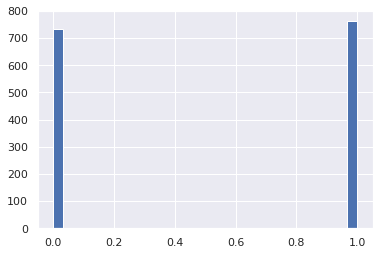

In [82]:
plt.hist(y_test_pred, bins=30)
plt.show()

In [83]:
roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_test_pred)

(1.0, 1.0)

In [84]:
thr = 0.5
print(classification_report(y_test, y_test_pred > thr))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00       732
        True       1.00      1.00      1.00       762

    accuracy                           1.00      1494
   macro avg       1.00      1.00      1.00      1494
weighted avg       1.00      1.00      1.00      1494



In [85]:
clf.predict(df.query('event_energy == 6 and event_class == "ER"')[clf_vars])

array([0.10150211])

In [86]:
clf.predict(df.query('event_energy == 10 and event_class == "NR"')[clf_vars])

array([0.70953011, 0.0414954 ])

In [91]:
df_6 = df[df['event_energy'] == 6]
df_6 = df_6.query('event_class != "ER"')
df_10 = df[df['event_energy'] == 10]
df_10 = df_10.query('event_class != "NR"')
df_6_vs_10 = pd.concat([df_6, df_10])



ER_predict = []
NR_predict = []
evl = []

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'max_depth': 4,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'early_stopping_rounds': 10
}


clf_vars = [
#               'chi2_pvalue_x', 'chi2_pvalue_y', 
#                'chi2_x', 'chi2_y',
              'dfr', 
              'dmu', 'dsigma', 
#               'fr_error_x', 'fr_error_y', 'fr_x', 'fr_y',
              'sigma_x', 'sigma_y', 
#               'sigma_error_x', 'sigma_error_y', 
              'mu_x', 'mu_y', 
#               'mu_error_x', 'mu_error_y', 
              'n_excess_bins_x', 'n_excess_bins_y', 
#                'nfcn_total_x', 'nfcn_total_y',
#        'nfcn_x', 'nfcn_y', 'ngrad_total_x', 'ngrad_total_y', 'ngrad_x', 'ngrad_y', 
              'sig_count_x', 'sig_count_y', 
              'sig_density_x', 'sig_density_y', 
#                'dsig_count'
              ]

X = df_6_vs_10[clf_vars]
y = df_6_vs_10['event_energy'] == 10

for rand_seed in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=rand_seed)
    
    lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
#     lgb_train = lgb.Dataset(X, y, free_raw_data=False)
#     lgb_eval = lgb.Dataset(X, y, reference=lgb_train)
    
    clf = lgb.train(
                params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,  # eval training data
                verbose_eval=-1,
#                 feature_name=X_train.columns,
#                 categorical_feature=[21]
               )

    ER_predict.append(clf.predict(df.query('event_energy == 6 and event_class == "ER"')[clf_vars]))
    NR_predict.append(clf.predict(df.query('event_energy == 10 and event_class == "NR"')[clf_vars]))
    
    y_test_pred = clf.predict(X_test)
    evl.append(roc_auc_score(y_test, y_test_pred))

Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[179]	valid_0's binary_logloss: 5.73219e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 2.56314e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[147]	valid_0's binary_logloss: 8.91457e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[188]	valid_0's binary_logloss: 2.74434e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[172]	valid_0's binary_logloss: 3.68154e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 2.9947e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[174]	valid_0's binary_logloss: 5.1551e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[177]	valid_0's binary_logloss: 1.77665e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[140]	valid_0's binary_logloss: 5.3437e-06
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 8.05994e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[175]	valid_0's binary_logloss: 9.64105e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[152]	valid_0's binary_logloss: 3.66946e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.00942028
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 2.86557e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[185]	valid_0's binary_logloss: 1.71109e-06


Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 6.06182e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[203]	valid_0's binary_logloss: 1.62363e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[178]	valid_0's binary_logloss: 6.4492e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[181]	valid_0's binary_logloss: 2.8132e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.0011102
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[174]	valid_0's binary_logloss: 1.86625e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[146]	valid_0's binary_logloss: 7.19956e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.0358707
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[166]	valid_0's binary_logloss: 2.18548e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[163]	valid_0's binary_logloss: 2.17129e-06
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[177]	valid_0's binary_logloss: 1.51839e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[174]	valid_0's binary_logloss: 2.93945e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[196]	valid_0's binary_logloss: 3.25223e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 4.18746e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[155]	valid_0's binary_logloss: 1.85834e-06
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[161]	valid_0's binary_logloss: 3.85062e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 9.76075e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[172]	valid_0's binary_logloss: 4.95941e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[177]	valid_0's binary_logloss: 5.0636e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[147]	valid_0's binary_logloss: 2.9734e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[149]	valid_0's binary_logloss: 3.58913e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[202]	valid_0's binary_logloss: 2.40397e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[143]	valid_0's binary_logloss: 5.81088e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[151]	valid_0's binary_logloss: 4.38529e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[179]	valid_0's binary_logloss: 2.63745e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.00603789
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 2.13366e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 3.59947e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[166]	valid_0's binary_logloss: 3.10667e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 2.17159e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[194]	valid_0's binary_logloss: 1.41135e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[149]	valid_0's binary_logloss: 1.06434e-06
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[177]	valid_0's binary_logloss: 3.40682e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[146]	valid_0's binary_logloss: 2.27615e-06
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[193]	valid_0's binary_logloss: 1.57662e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 1.06894e-06
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[179]	valid_0's binary_logloss: 2.071e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[207]	valid_0's binary_logloss: 2.68243e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 2.19386e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[185]	valid_0's binary_logloss: 5.58442e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[178]	valid_0's binary_logloss: 2.94152e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[184]	valid_0's binary_logloss: 3.88326e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[159]	valid_0's binary_logloss: 3.06611e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[189]	valid_0's binary_logloss: 3.3393e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[166]	valid_0's binary_logloss: 3.3266e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[168]	valid_0's binary_logloss: 2.27095e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[169]	valid_0's binary_logloss: 4.87928e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[167]	valid_0's binary_logloss: 2.73778e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.00309597
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[149]	valid_0's binary_logloss: 3.30131e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[159]	valid_0's binary_logloss: 1.60506e-06
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[172]	valid_0's binary_logloss: 2.19919e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[171]	valid_0's binary_logloss: 2.28425e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[187]	valid_0's binary_logloss: 2.99243e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 2.05766e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[161]	valid_0's binary_logloss: 2.44536e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[166]	valid_0's binary_logloss: 4.61103e-06


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[161]	valid_0's binary_logloss: 2.88537e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[167]	valid_0's binary_logloss: 4.77896e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[152]	valid_0's binary_logloss: 2.49711e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 2.92433e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[139]	valid_0's binary_logloss: 1.32143e-05


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.00374033
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[143]	valid_0's binary_logloss: 4.11288e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[152]	valid_0's binary_logloss: 3.76016e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[172]	valid_0's binary_logloss: 2.15044e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[178]	valid_0's binary_logloss: 1.30729e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[150]	valid_0's binary_logloss: 6.43727e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[186]	valid_0's binary_logloss: 2.10284e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 5.63548e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[152]	valid_0's binary_logloss: 4.96122e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 4.05163e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[186]	valid_0's binary_logloss: 2.18939e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 2.30366e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[210]	valid_0's binary_logloss: 2.83483e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[206]	valid_0's binary_logloss: 2.2819e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 8.86849e-05
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[135]	valid_0's binary_logloss: 1.07028e-05
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[152]	valid_0's binary_logloss: 3.49258e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[216]	valid_0's binary_logloss: 1.80369e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[168]	valid_0's binary_logloss: 3.27086e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[194]	valid_0's binary_logloss: 4.55464e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[172]	valid_0's binary_logloss: 5.66856e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[190]	valid_0's binary_logloss: 1.05303e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[151]	valid_0's binary_logloss: 3.54509e-07


Found `early_stopping_rounds` in params. Will use it instead of argument


In [92]:
sum([ER_predict[i][0]>0.5 for i in range(len(ER_predict))])

49

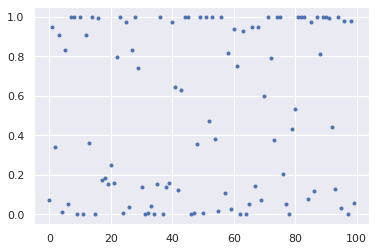

In [93]:
plt.plot(ER_predict, '.')

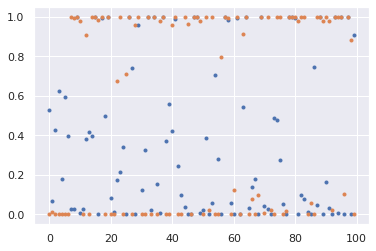

In [94]:
plt.plot(NR_predict, '.')

In [21]:
df_6 = df[df['event_energy'] == 6]
df_10 = df[df['event_energy'] == 10]
df_6_vs_10 = pd.concat([df_6, df_10])

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'max_depth': 4,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'early_stopping_rounds': 10
}

ER_predict = []
NR_predict = []
evl = []

clf_vars_with_name = [
              'dfr', 
              'dmu', 'dsigma', 
              'sigma_x', 'sigma_y', 
              'mu_x', 'mu_y', 
              'n_excess_bins_x', 'n_excess_bins_y', 
              'sig_count_x', 'sig_count_y', 
              'sig_density_x', 'sig_density_y', 
              'image_name'
              ]

clf_vars = list(set(clf_vars_with_name) - set(['image_name']))

X = df_6_vs_10[clf_vars_with_name]
y = df_6_vs_10['event_energy'] == 10

names_of_im = []

for rand_seed in range(100):
    X_train_with_name, X_test_with_name, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=rand_seed)
    X_train, X_test = X_train_with_name.drop(['image_name'], axis=1), X_test_with_name.drop(['image_name'], axis=1)
    lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
#     lgb_train = lgb.Dataset(X, y, free_raw_data=False)
#     lgb_eval = lgb.Dataset(X, y, reference=lgb_train)
    
    clf = lgb.train(
                params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,  # eval training data
                verbose_eval=-1,
#                 feature_name=X_train.columns,
#                 categorical_feature=[21]
               )

    ER_predict.append(clf.predict(df.query('event_energy == 6 and event_class == "ER"')[clf_vars]))
    NR_predict.append(clf.predict(df.query('event_energy == 10 and event_class == "NR"')[clf_vars]))
    
    y_test_pred = clf.predict(X_test)
    evl.append(roc_auc_score(y_test, y_test_pred))
    
    if ER_predict[-1][0] > 1e-3:
        names_of_im.append(X_train_with_name['image_name'])
    if NR_predict[-1][0] < 1 - 1e-3:
        names_of_im.append(X_train_with_name['image_name'])
    if NR_predict[-1][1] < 1 - 1e-3:
        names_of_im.append(X_train_with_name['image_name'])

Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.022573
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.00419496
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 2.03246e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 6.38516e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[172]	valid_0's binary_logloss: 2.42974e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[193]	valid_0's binary_logloss: 2.43834e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[162]	valid_0's binary_logloss: 1.88618e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 4.81028e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[190]	valid_0's binary_logloss: 2.22768e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[184]	valid_0's binary_logloss: 2.57227e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.0314116
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[185]	valid_0's binary_logloss: 1.89799e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[169]	valid_0's binary_logloss: 3.26714e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[165]	valid_0's binary_logloss: 8.86859e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[110]	valid_0's binary_logloss: 6.09701e-05


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[189]	valid_0's binary_logloss: 2.08762e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 1.69211e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 2.96521e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[200]	valid_0's binary_logloss: 2.4178e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[207]	valid_0's binary_logloss: 1.51667e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[177]	valid_0's binary_logloss: 1.5971e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[185]	valid_0's binary_logloss: 1.69889e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[169]	valid_0's binary_logloss: 3.93786e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[169]	valid_0's binary_logloss: 2.74971e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[171]	valid_0's binary_logloss: 3.98758e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 1.89795e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.00132558
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 2.82044e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.00108173
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[177]	valid_0's binary_logloss: 1.99051e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 2.13466e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[175]	valid_0's binary_logloss: 2.31772e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[175]	valid_0's binary_logloss: 2.55242e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[182]	valid_0's binary_logloss: 1.86402e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 3.38507e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[189]	valid_0's binary_logloss: 3.0807e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[218]	valid_0's binary_logloss: 3.9945e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[182]	valid_0's binary_logloss: 3.7814e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[148]	valid_0's binary_logloss: 4.37821e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[206]	valid_0's binary_logloss: 2.29013e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[165]	valid_0's binary_logloss: 3.23082e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[172]	valid_0's binary_logloss: 3.02833e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 1.95831e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[146]	valid_0's binary_logloss: 5.10054e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[150]	valid_0's binary_logloss: 5.89805e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[185]	valid_0's binary_logloss: 1.8994e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[179]	valid_0's binary_logloss: 4.9506e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[168]	valid_0's binary_logloss: 3.36168e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[198]	valid_0's binary_logloss: 1.57592e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 4.11316e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[167]	valid_0's binary_logloss: 2.87009e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 2.74837e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 3.5841e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[152]	valid_0's binary_logloss: 3.09501e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[190]	valid_0's binary_logloss: 3.75138e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[159]	valid_0's binary_logloss: 3.28025e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[179]	valid_0's binary_logloss: 3.30959e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 6.76064e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 6.74425e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[143]	valid_0's binary_logloss: 1.00085e-06


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[149]	valid_0's binary_logloss: 7.20459e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.0247163
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[190]	valid_0's binary_logloss: 1.86086e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[172]	valid_0's binary_logloss: 1.12582e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[156]	valid_0's binary_logloss: 8.25884e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 2.8934e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[212]	valid_0's binary_logloss: 2.9685e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[188]	valid_0's binary_logloss: 1.39432e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[159]	valid_0's binary_logloss: 3.38687e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[148]	valid_0's binary_logloss: 8.71889e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.00295861


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[196]	valid_0's binary_logloss: 1.835e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[181]	valid_0's binary_logloss: 3.53135e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[175]	valid_0's binary_logloss: 3.05315e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[193]	valid_0's binary_logloss: 1.10327e-06


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[175]	valid_0's binary_logloss: 2.92847e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[169]	valid_0's binary_logloss: 6.68108e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[162]	valid_0's binary_logloss: 2.32095e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[150]	valid_0's binary_logloss: 9.18622e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[155]	valid_0's binary_logloss: 3.5031e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[163]	valid_0's binary_logloss: 2.71656e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[193]	valid_0's binary_logloss: 3.06634e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 3.92633e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[179]	valid_0's binary_logloss: 5.43406e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[168]	valid_0's binary_logloss: 4.37333e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 1.55143e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 2.76355e-06


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[155]	valid_0's binary_logloss: 8.30886e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[163]	valid_0's binary_logloss: 6.52379e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[178]	valid_0's binary_logloss: 2.2966e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[167]	valid_0's binary_logloss: 3.45118e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[169]	valid_0's binary_logloss: 6.5999e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[207]	valid_0's binary_logloss: 1.05868e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 2.28478e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[175]	valid_0's binary_logloss: 2.89074e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[169]	valid_0's binary_logloss: 9.32268e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[181]	valid_0's binary_logloss: 2.91512e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[163]	valid_0's binary_logloss: 2.44977e-06
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.0178201
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[185]	valid_0's binary_logloss: 3.1436e-07


In [22]:
print('validation roc auc: {:f}+-{:f} '.format(np.mean(evl), np.std(evl)))

validation roc auc: 1.000000+-0.000000 


In [23]:
sum([ER_predict[i][0] > 1e-1 for i in range(len(ER_predict))]) / len(ER_predict)

0.06

In [24]:
sum([NR_predict[i][0] < 1 - 1e-1 for i in range(len(NR_predict))]) / len(NR_predict)

0.99

In [25]:
sum([NR_predict[i][1] < 1 - 1e-1 for i in range(len(NR_predict))]) / len(NR_predict)

0.99

In [26]:
clf.predict(df.query('event_energy == 6 and event_class == "ER"')[clf_vars])

array([0.00017111])

In [27]:
clf.predict(df.query('event_energy == 10 and event_class == "NR"')[clf_vars])

array([0.00039627, 0.00017111])

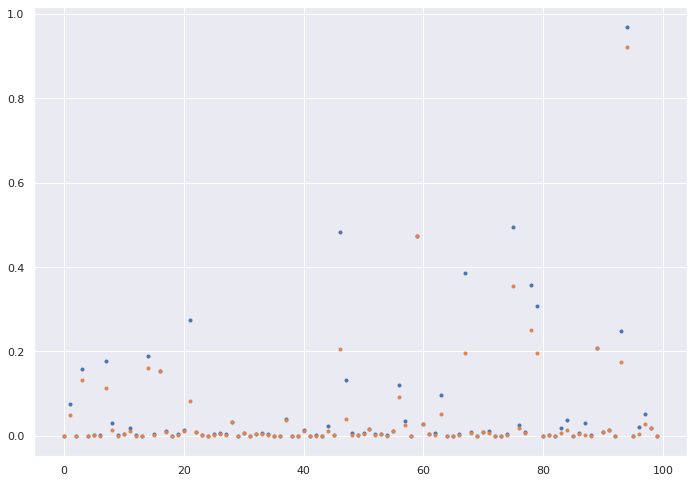

In [18]:
plt.plot(NR_predict, '.')

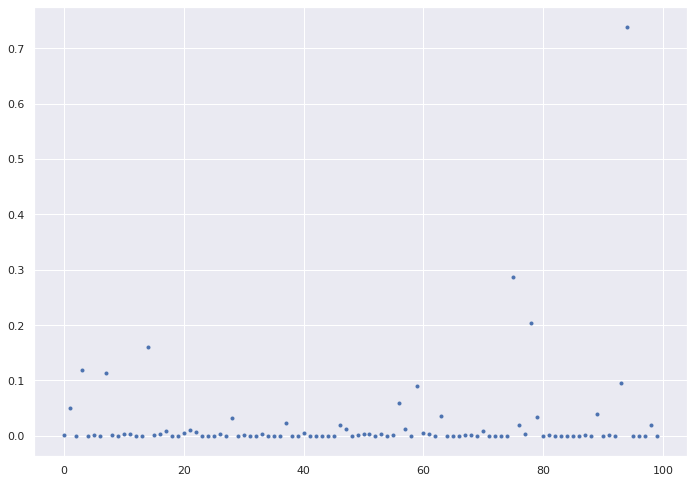

In [19]:
plt.plot(ER_predict, '.')

In [298]:
len(np.array(ER_predict) > 1e-3)

100

In [303]:
ER_predict[i][0] 

0.000626999979038454

In [ ]:
plt.plot(NR_predict, '.')

In [305]:
intersection = names_of_im[0]
for i in range(1,len(names_of_im)):
    intersection = list(set(names_of_im[i]).intersection(intersection))

In [306]:
len(intersection)

4

In [292]:
from utils import *

### 

In [295]:
intersection

['-3.0945000648498535__CYGNO_60_40_He_NR_6_keV_930V_30cm_SRIM_IDAO_iso_crop_hist_pic_run4_ev409',
 '0.0940999984741211__CYGNO_60_40_He_NR_6_keV_930V_30cm_SRIM_IDAO_iso_crop_hist_pic_run1_ev125',
 '-0.5180000066757202__CYGNO_60_40_He_NR_6_keV_930V_30cm_SRIM_IDAO_iso_crop_hist_pic_run3_ev476',
 '-1.6073999404907227__CYGNO_60_40_He_NR_6_keV_930V_30cm_SRIM_IDAO_iso_crop_hist_pic_run5_ev441']

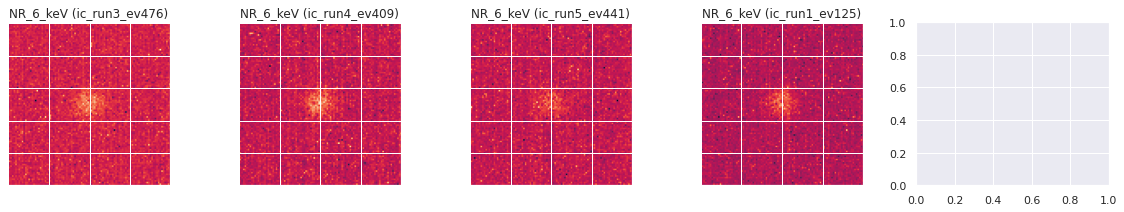

In [293]:
tmp = plot_images('../../idao_dataset/', im_filename=intersection)

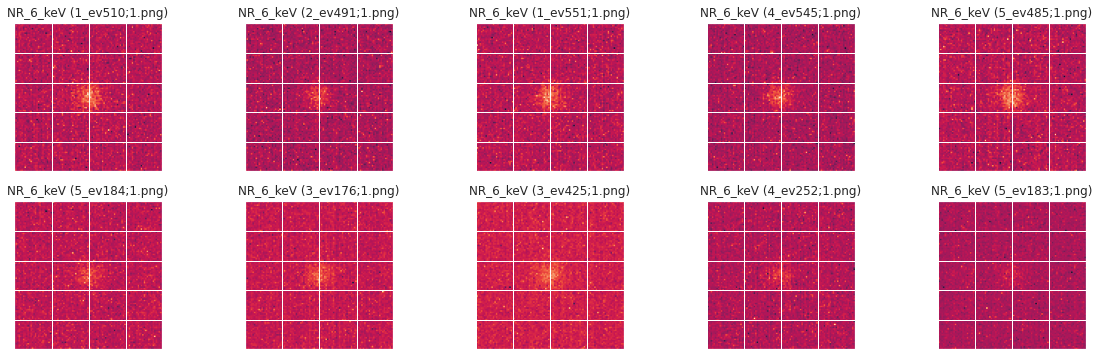

In [294]:
tmp = plot_images('../../idao_dataset/', class_to_plot='NR', energy_to_plot=6, max_num_images=10, rand_seed=10)

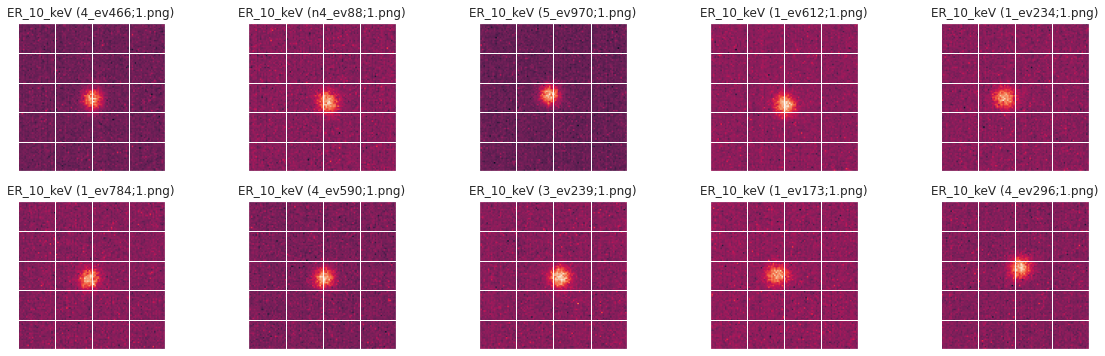

In [345]:
tmp = plot_images('../../idao_dataset/', class_to_plot='ER', energy_to_plot=10, max_num_images=10, rand_seed=10)

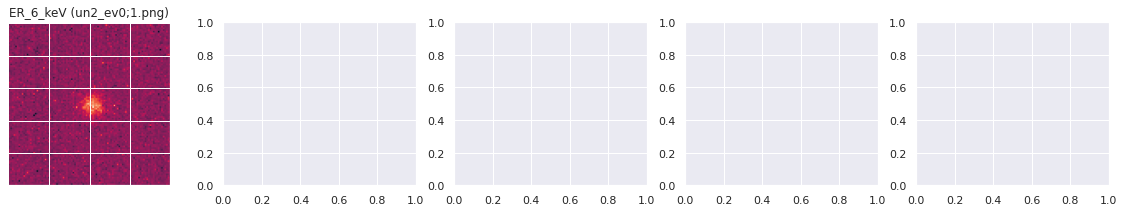

In [115]:
tmp = plot_images('../../idao_dataset/', class_to_plot='ER', energy_to_plot=6, max_num_images=10, rand_seed=10)

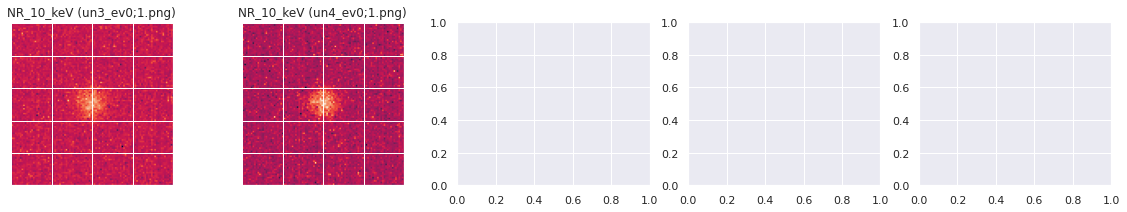

In [116]:
tmp = plot_images('../../idao_dataset/', class_to_plot='NR', energy_to_plot=10, max_num_images=10, rand_seed=10)

In [118]:
df.query('event_energy == 10 and event_class == "NR"')[clf_vars]

dfr       dmu    dsigma   sigma_x   sigma_y        mu_x  \
2586 -0.000517 -0.737608 -1.797976  4.516990  6.314966  287.439026   
3573  0.000325  1.640990  0.257050  5.799134  5.542084  289.311151   

            mu_y  n_excess_bins_x  n_excess_bins_y  sig_count_x  sig_count_y  \
2586  288.176635             74.0             69.0  3904.511020  4655.073580   
3573  287.670160             70.0             72.0  4945.396063  4474.071746   

      sig_density_x  sig_density_y  
2586     864.405486     737.149408  
3573     852.781837     807.290444

In [126]:
df.query('event_energy == 6 and event_class == "ER"')[clf_vars]

dfr       dmu   dsigma   sigma_x   sigma_y        mu_x        mu_y  \
2950  0.000757  1.833169  1.08763  5.614171  4.526541  290.983368  289.150199   

      n_excess_bins_x  n_excess_bins_y  sig_count_x  sig_count_y  \
2950             73.0             76.0  5228.698547  4131.699865   

      sig_density_x  sig_density_y  
2950     931.339372     912.771956

In [124]:
np.mean(df.query('event_energy == 10 and event_class == "ER"')[clf_vars]).T

dfr                  -0.000022
dmu                  -0.152783
dsigma               -0.049326
sigma_x               4.824628
sigma_y               4.873954
mu_x                287.182615
mu_y                287.335397
n_excess_bins_x      70.223592
n_excess_bins_y      72.225792
sig_count_x        6576.167639
sig_count_y        6608.792570
sig_density_x      1378.240618
sig_density_y      1366.134304
dtype: float64

In [127]:
np.mean(df.query('event_energy == 6 and event_class == "NR"')[clf_vars]).T

dfr                   0.000040
dmu                   0.016598
dsigma                0.052693
sigma_x               6.010567
sigma_y               5.957874
mu_x                288.006889
mu_y                287.990290
n_excess_bins_x      67.959202
n_excess_bins_y      72.006208
sig_count_x        2613.825187
sig_count_y        2556.805940
sig_density_x       462.862970
sig_density_y       431.197655
dtype: float64

In [96]:
from utils import *

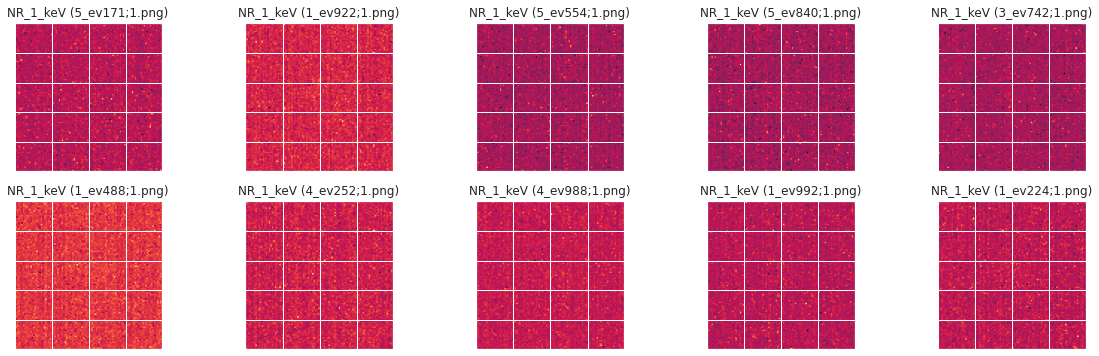

In [97]:
tmp = plot_images('../../idao_dataset/', class_to_plot='NR', energy_to_plot=1, max_num_images=10, rand_seed=10)

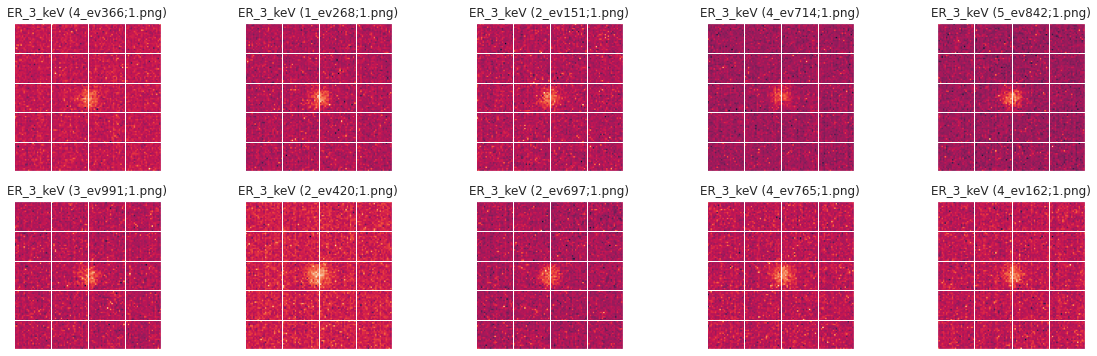

In [98]:
tmp = plot_images('../../idao_dataset/', class_to_plot='ER', energy_to_plot=3, max_num_images=10, rand_seed=10)

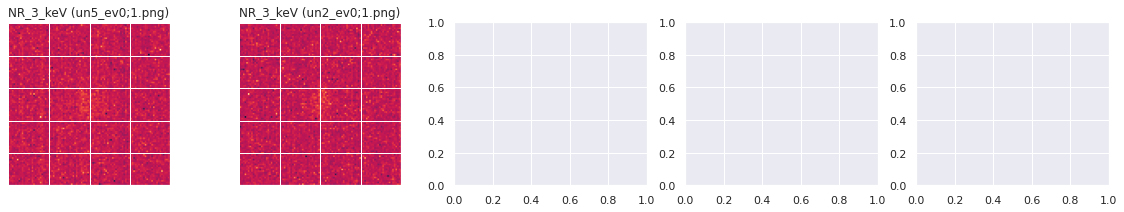

In [101]:
tmp1 = plot_images('../../idao_dataset/', class_to_plot='NR', energy_to_plot=3, max_num_images=10, rand_seed=10)

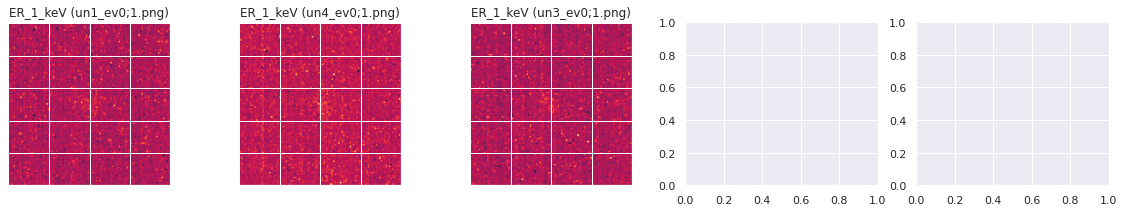

In [102]:
tmp2 = plot_images('../../idao_dataset/', class_to_plot='ER', energy_to_plot=1, max_num_images=10, rand_seed=10)

In [110]:
np.mean(tmp1[1][:,0])

100.79

In [109]:
np.mean(tmp2[2][:,0])

97.22

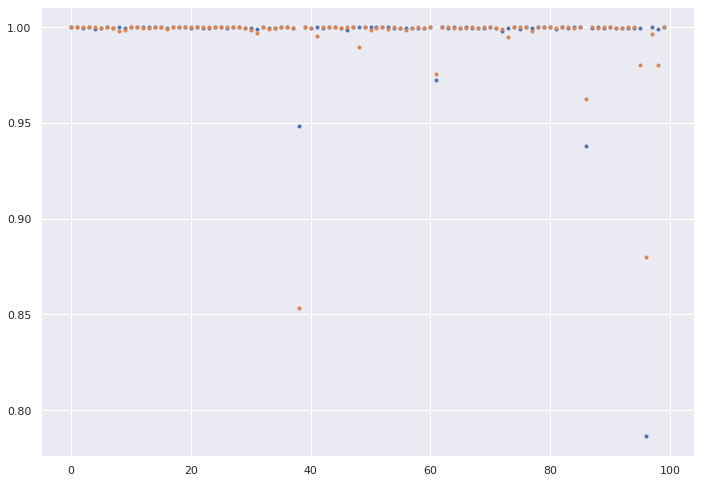

In [268]:
plt.plot(NR_predict, '.')

In [214]:
clf.predict(df.query('event_energy == 6 and event_class == "ER"')[clf_vars])

array([0.99577875])

In [215]:
clf.predict(df.query('event_energy == 10 and event_class == "NR"')[clf_vars])

array([0.99449847, 0.94273985])

In [59]:
# from sklearn.model_selection import StratifiedKFold

# kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# roc_auc = []

# i = 0
# for train, test in kfold.split(X, y):
    
#     lgb_train = lgb.Dataset(X.iloc[train], y.iloc[train], free_raw_data=False)
#     lgb_eval = lgb.Dataset(X.iloc[test], y.iloc[test], reference=lgb_train)

#     clf = lgb.train(
#                 params,
#                 lgb_train,
#                 num_boost_round=1000,
#                 valid_sets=lgb_eval,  # eval training data
#                 verbose_eval=True,
#     #                 feature_name=X_train.columns,
#     #                 categorical_feature=[21]
#                )
#     y_test_pred = clf.predict(X.iloc[test])
#     roc_auc.append(roc_auc_score(y.iloc[test], y_test_pred))
#     print("Test set ROC_AUC for {} cycle:{}".format(i+1,roc_auc[i]))
#     i+=1

# print("Mean ROC_AUC for {}-fold cross validation : {}".format(len(roc_auc), np.mean(roc_auc)))

In [30]:
df.query('event_energy == 10 and event_class == "NR"')['image_name']

2586    2.4159998893737793__CYGNO_60_40_He_NR_10_keV_9...
3573    -0.9444000124931335__CYGNO_60_40_He_NR_10_keV_...
Name: image_name, dtype: object

In [29]:
df.query('event_energy == 10 and event_class == "NR"')[clf_vars]

dfr       dmu    dsigma   sigma_x   sigma_y        mu_x  \
2586 -0.000517 -0.737608 -1.797976  4.516990  6.314966  287.439026   
3573  0.000325  1.640990  0.257050  5.799134  5.542084  289.311151   

            mu_y  n_excess_bins_x  n_excess_bins_y  sig_count_x  sig_count_y  \
2586  288.176635             74.0             69.0  3904.511020  4655.073580   
3573  287.670160             70.0             72.0  4945.396063  4474.071746   

      sig_density_x  sig_density_y  
2586     864.405486     737.149408  
3573     852.781837     807.290444

In [117]:
y_public_pred_clf = clf.predict(df_public[clf_vars])
y_private_pred_clf = clf.predict(df_private[clf_vars])

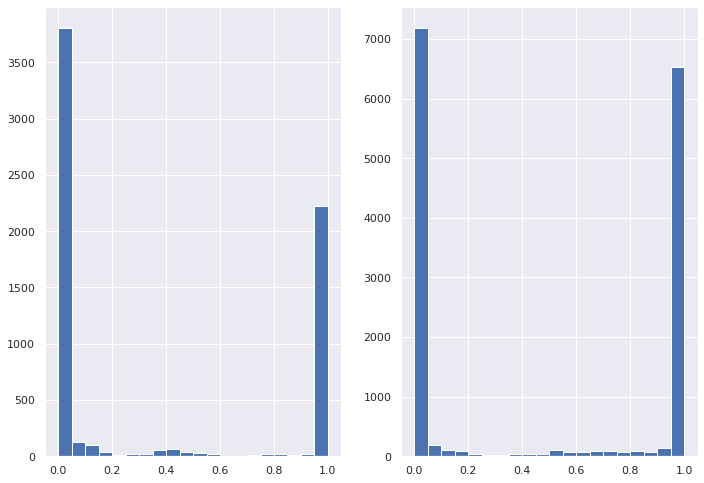

In [118]:
fig, axs = plt.subplots(1, 2)
axs[0].hist(y_public_pred_clf, bins=20)
axs[1].hist(y_private_pred_clf, bins=20)
plt.show()

In [119]:
sum(y_public_pred_clf > 0.5), sum(y_private_pred_clf > 0.5)

(2358, 7318)

In [120]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


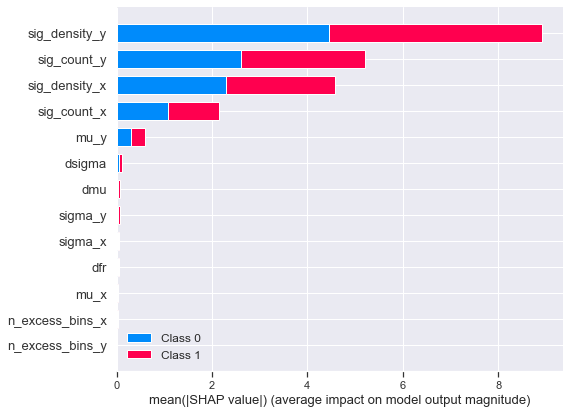

In [116]:
shap.summary_plot(shap_values, X)

In [117]:
thr = 0.05
thr_clf = 0.5
sc_private_nw_6 = df_private[(y_private_pred<thr) & (y_private_pred_clf<thr_clf)].sig_count_y
sc_private_nw_10 = df_private[(y_private_pred<thr) & (y_private_pred_clf>=thr_clf)].sig_count_y
sc_private_w = df_private[y_private_pred>=thr].sig_count_y
E_pred_private_nw_6 = invert_regr(regr, sc_private_nw_6)
E_pred_private_nw_10 = invert_regr(regr, sc_private_nw_10)
E_pred_private_w = invert_regr(regr, sc_private_w)
min(E_pred_private_nw), max(E_pred_private_nw)

(-4.796772441136632, 38.45373001985319)

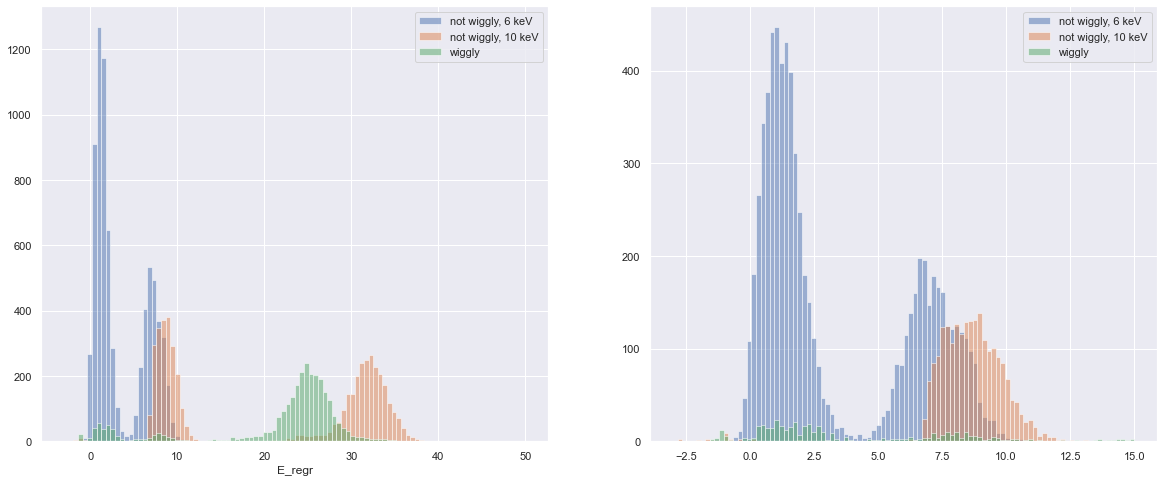

In [118]:
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].hist(E_pred_private_nw_6, bins=100, range=(-3, 50), alpha=0.5, label='not wiggly, 6 keV')
axs[0].hist(E_pred_private_nw_10, bins=100, range=(-3, 50), alpha=0.5, label='not wiggly, 10 keV')
axs[0].hist(E_pred_private_w, bins=100, range=(-3, 50), alpha=0.5, label='wiggly')
axs[0].set_xlabel('E_regr')
axs[0].legend()
axs[1].hist(E_pred_private_nw_6, bins=100, range=(-3, 15), alpha=0.5, label='not wiggly, 6 keV')
axs[1].hist(E_pred_private_nw_10, bins=100, range=(-3, 15), alpha=0.5, label='not wiggly, 10 keV')
axs[1].hist(E_pred_private_w, bins=100, range=(-3, 15), alpha=0.5, label='wiggly')
axs[0].set_xlabel('E_regr')
axs[1].legend()
plt.show()

In [119]:
sum(E_pred_private_nw_10 < 15)

2172

### dev

<AxesSubplot:xlabel='sig_density_y', ylabel='Count'>

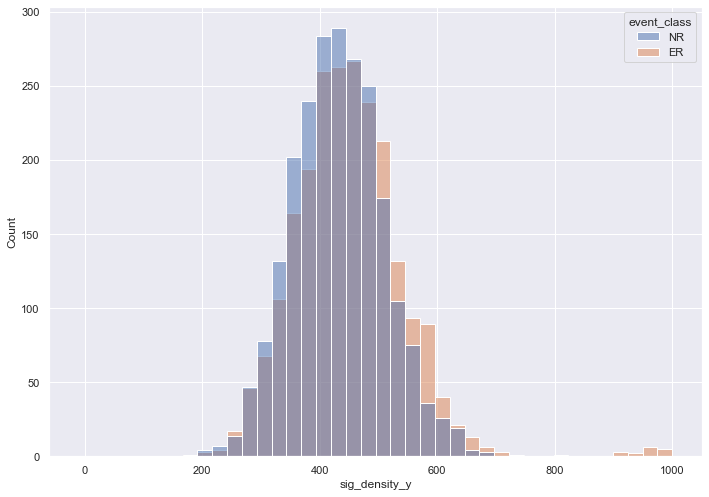

In [120]:
sns.histplot(x='sig_density_y', data=df.query('event_energy > 1 and event_energy < 30'), hue='event_class', bins=40, binrange=(-10, 1000))

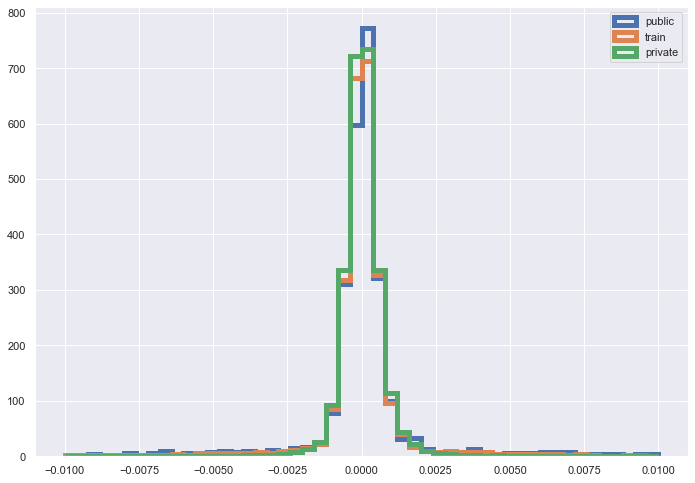

In [121]:
plt.hist(df_public.dfr, bins=50, range=(-.01, 0.01), linewidth=5, density=True, histtype='step', label='public')
plt.hist(df.dfr, bins=50, range=(-.01, 0.01), linewidth=5, density=True, histtype='step', label='train')
plt.hist(df_private.dfr, bins=50, range=(-.01, 0.01), linewidth=5, density=True, histtype='step', label='private')
plt.legend()
plt.show()